### Downloading and Loading Dataset

You can download the dataset from Kaggle
- Option 1: Dataset Source: https://www.kaggle.com/datasets/niteshfre/chessman-image-dataset/data
- Option 2: Data present in this repository in `Chessmen_Image_Data` folder.

**Use Option 2 for simplicity, I have updated the data directory `path` or `DATA_DIR` to `Chessmen_Image_Data`**

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

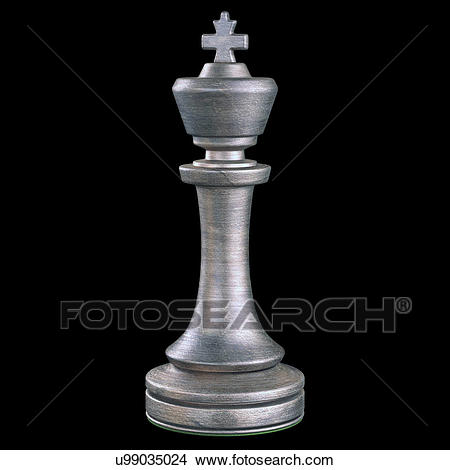

In [4]:
path = 'Chessmen_Images_Data/King'
name = '00000015.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

### EDA

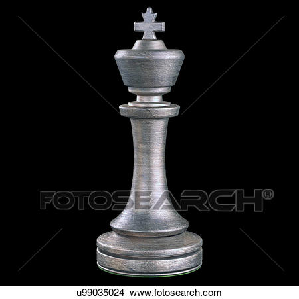

In [4]:
img = load_img(fullname, target_size=(299, 299))
img

In [5]:
DATA_DIR = 'Chessmen_Images_Data'
image_size = (150, 150)
batch_size = 32

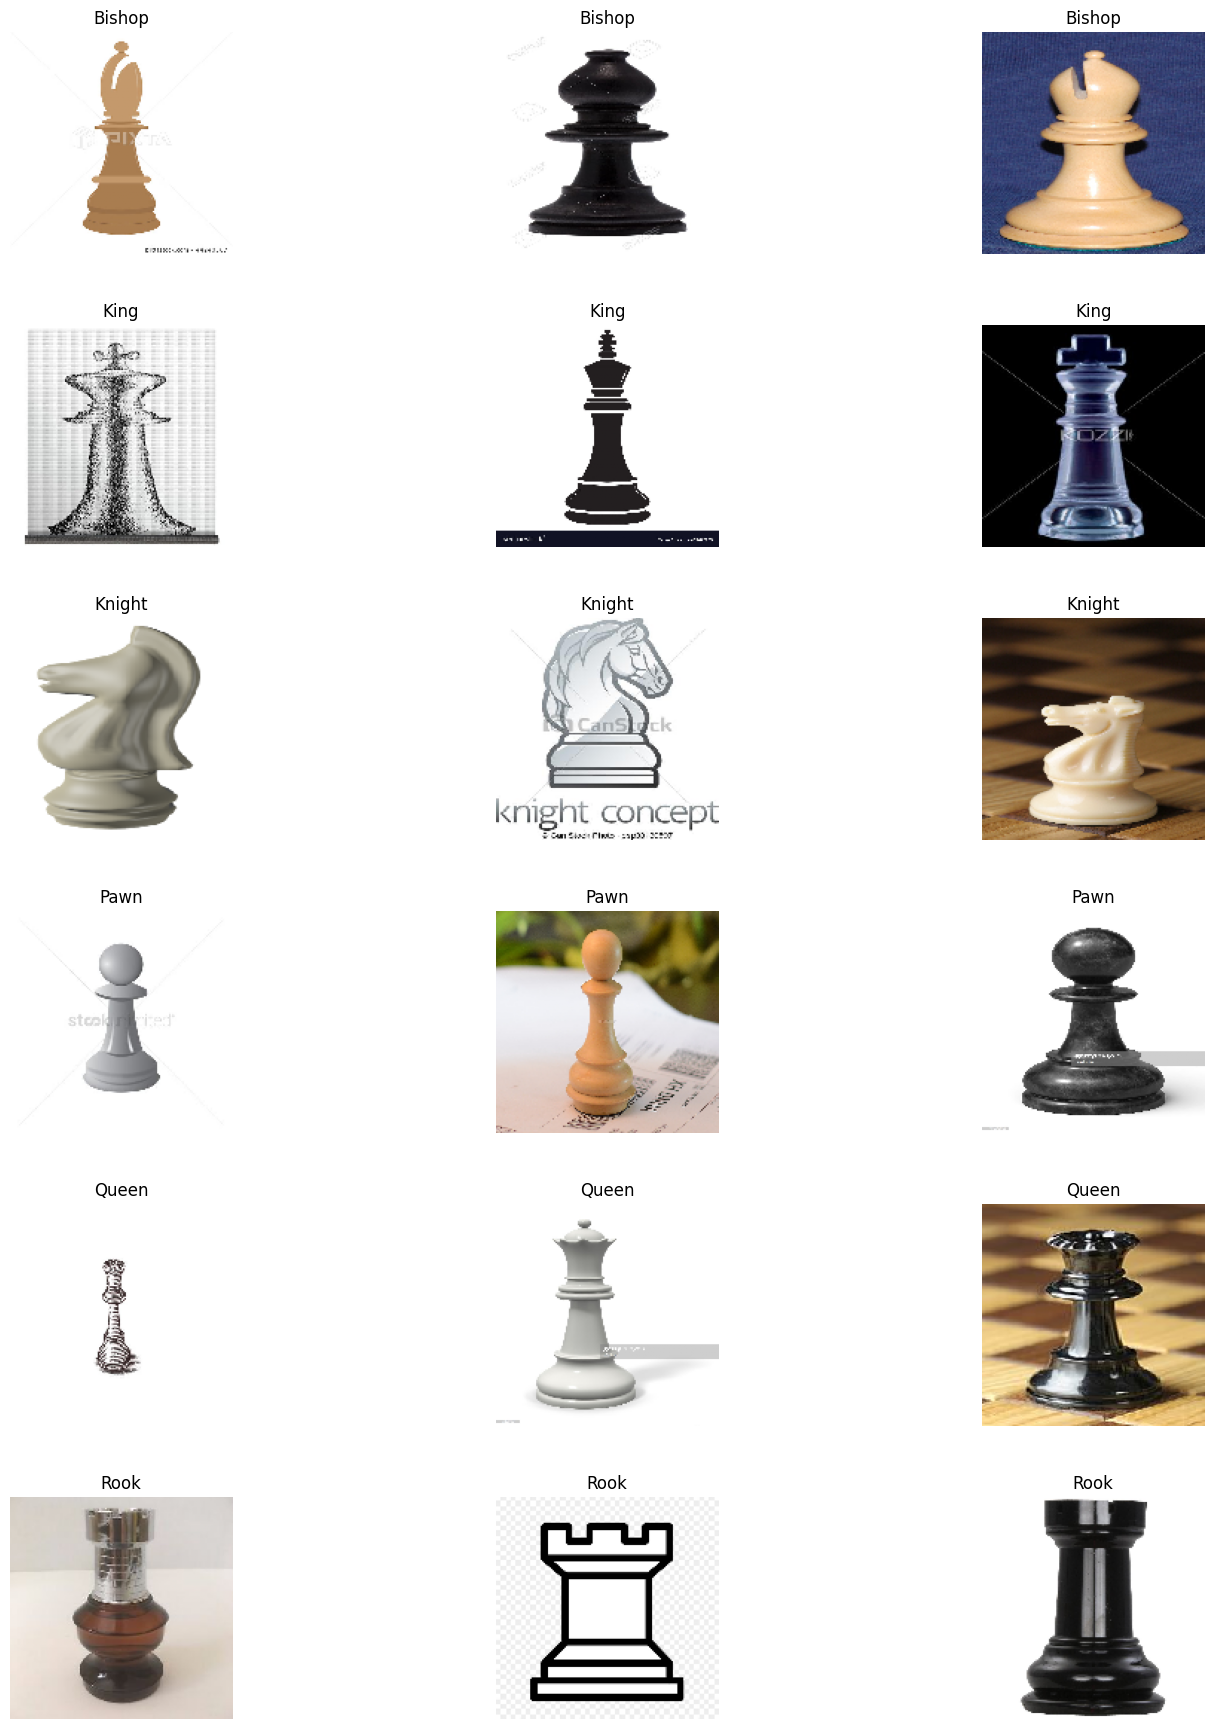

In [6]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def plot_images_from_directory(data_dir, image_size=(150, 150), images_per_class=3):
    """
    Plots a grid of images with a given number of samples per class from the directory.

    Args:
    - data_dir: Path to the dataset directory.
    - image_size: Tuple for resizing the images.
    - images_per_class: Number of images to show per class.
    """
    # Get all class directories
    class_names = sorted(os.listdir(data_dir))

    # Initialize a figure
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, images_per_class, figsize=(15, num_classes * 3))
    fig.tight_layout(pad=3.0)

    for row, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        image_files = os.listdir(class_dir)[:images_per_class]  # Get the first 'images_per_class' images

        for col, image_file in enumerate(image_files):
            image_path = os.path.join(class_dir, image_file)
            img = load_img(image_path, target_size=image_size)  # Load and resize the image
            img_array = img_to_array(img).astype("uint8")  # Convert to array for plotting

            # Plot the image
            axes[row, col].imshow(img_array / 255.0)  # Normalize for better visualization
            axes[row, col].axis('off')
            axes[row, col].set_title(class_name)

    plt.show()

# Call the function to plot images
plot_images_from_directory(DATA_DIR, image_size=(150, 150), images_per_class=3)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2  # Split 20% for validation
)

# Training data
train_ds = train_gen.flow_from_directory(
    DATA_DIR,
    target_size=(150, 150),
    batch_size=32,
    subset='training'  # Get the training data
)

# Validation data
val_ds = train_gen.flow_from_directory(
    DATA_DIR,
    target_size=(150, 150),
    batch_size=32,
    subset='validation'  # Get the validation data
)

Found 442 images belonging to 6 classes.
Found 109 images belonging to 6 classes.


In [ ]:
train_ds.class_indices

{'Bishop': 0, 'King': 1, 'Knight': 2, 'Pawn': 3, 'Queen': 4, 'Rook': 5}

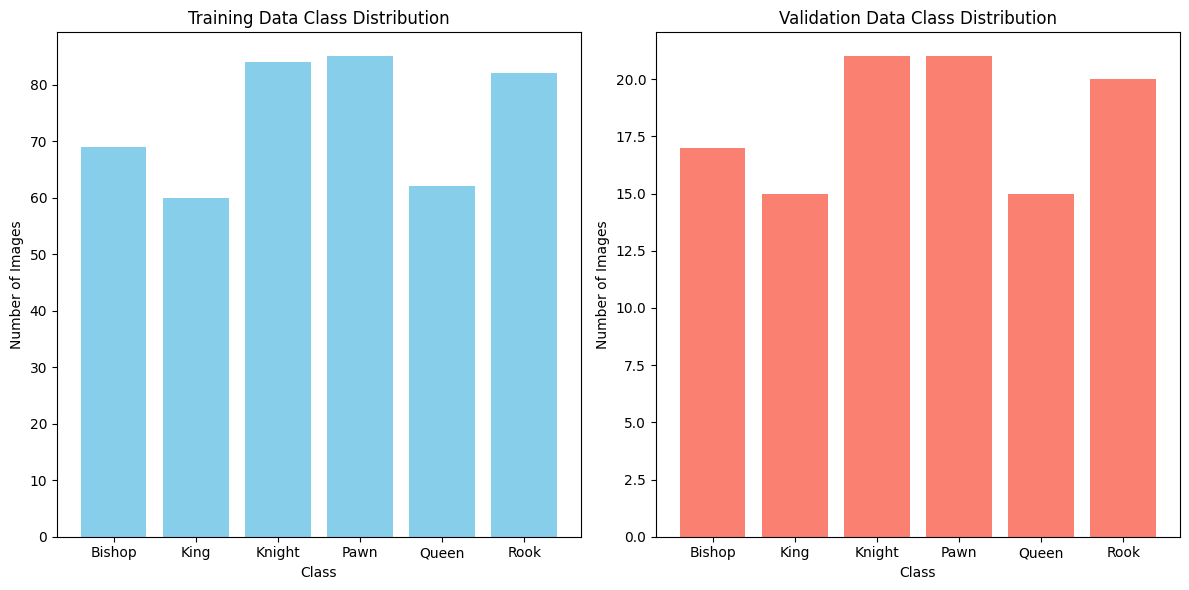

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract class labels and counts from the training data generator
train_classes = train_ds.classes
val_classes = val_ds.classes

# Get the mapping of class indices to class labels
class_labels = list(train_ds.class_indices.keys())

# Count the number of images in each class
train_class_counts = np.bincount(train_classes)
val_class_counts = np.bincount(val_classes)

# Plot the distribution for training data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(class_labels, train_class_counts, color='skyblue')
plt.title('Training Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')

# Plot the distribution for validation data
plt.subplot(1, 2, 2)
plt.bar(class_labels, val_class_counts, color='salmon')
plt.title('Validation Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()


#### Data Augmentation
- This helps to train the model on different variations of images and increases the accuracy

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

# Data augmentation for training
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,            # Rotate images randomly up to 30 degrees
    width_shift_range=0.2,        # Shift images horizontally by 20% of the width
    height_shift_range=0.2,       # Shift images vertically by 20% of the height
    validation_split=0.2          # Split 20% for validation
)

# No data augmentation for validation

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2  # Split 20% for validation
)

# Training data
train_ds = train_gen.flow_from_directory(
    DATA_DIR,
    target_size=(150, 150),
    batch_size=32,
    subset='training',  # Get the training data
    shuffle=True        # Shuffle training data
)

# Validation data
val_ds = val_gen.flow_from_directory(
    DATA_DIR,
    target_size=(150, 150),
    batch_size=32,
    subset='validation',  # Get the validation data
    shuffle=False         # Typically, no need to shuffle validation data
)


Found 442 images belonging to 6 classes.
Found 109 images belonging to 6 classes.


### Models Training and Selectiion

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, val_ds):
    """
    Evaluates the given model on the validation dataset, prints accuracy,
    and plots the confusion matrix.

    Args:
    - model: The trained Keras model to evaluate.
    - val_ds: The validation dataset (ImageDataGenerator or similar).

    Returns:
    - val_accuracy: The accuracy score on the validation set.
    """
    # Step 1: Predict on the validation set
    y_pred = model.predict(val_ds)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class indices

    # Step 2: Extract true labels from val_ds
    y_true = val_ds.classes  # True labels are stored in `classes` attribute of the generator

    # Step 3: Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    # Step 4: Calculate validation accuracy
    val_accuracy = accuracy_score(y_true, y_pred_classes)
    print(f"Validation Accuracy: {val_accuracy:.2%}")

    # Step 5: Visualize the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=val_ds.class_indices.keys(),
                yticklabels=val_ds.class_indices.keys())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return val_accuracy


### VGG Model

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define VGG19-based model with dropout
def create_vgg19_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.001, dropout_rate=0.5):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model
    base_model.trainable = True

    # Freeze all layers except the last few (to fine-tune only the last layers)
    for layer in base_model.layers[:-4]:  # Unfreeze the last k layers
        layer.trainable = False

    model = models.Sequential([
        base_model,  # Add VGG19 as base model (without top layer)
        layers.GlobalAveragePooling2D(),  # Pooling layer to reduce spatial dimensions
        layers.Dropout(dropout_rate),  # Add dropout layer after pooling for regularization
        layers.Dense(512, activation='relu'),  # Fully connected layer with ReLU activation
        layers.Dropout(dropout_rate),  # Dropout after the dense layer
        layers.Dense(num_classes, activation='softmax')  # Output layer with softmax for classification
    ])

    # Compile the model with custom learning rate
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),  # Set the learning rate here
        loss='categorical_crossentropy',  # Multi-class classification
        metrics=['accuracy']
    )

    return model


**What does Learning Scheduler do?**

The ReduceLROnPlateau callback reduces the learning rate when the validation loss stops improving, allowing the model to make finer updates to its weights in a smaller, more controlled manner. It helps the model avoid overshooting the optimal weights when training begins to converge.



#### Model training

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Create the model (if needed, use a lower learning rate)
model = create_vgg19_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.00005, dropout_rate=0.4)
model.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,290,118 (77.40 MB)

 Trainable params: 7,345,158 (28.02 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[lr_scheduler]  # Optional: continue with LR scheduler
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.1423 - loss: 1.9886 - val_accuracy: 0.4495 - val_loss: 1.6097 - learning_rate: 5.0000e-05
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 384ms/step - accuracy: 0.2615 - loss: 1.7494 - val_accuracy: 0.5046 - val_loss: 1.3683 - learning_rate: 5.0000e-05
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 402ms/step - accuracy: 0.4039 - loss: 1.5178 - val_accuracy: 0.6055 - val_loss: 1.0545 - learning_rate: 5.0000e-05
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 321ms/step - accuracy: 0.5427 - loss: 1.2736 - val_accuracy: 0.7339 - val_loss: 0.8413 - learning_rate: 5.0000e-05
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 411ms/step - accuracy: 0.5745 - loss: 1.0786 - val_accuracy: 0.7982 - val_loss: 0.7172 - learning_rate: 5.0000e-05
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step - accuracy: 0.6762 - loss: 0.9484 - val_accuracy: 0.7890 - val_loss: 0.5350 - learning_rate: 5.0000e-05
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 392ms/step - accuracy: 0.7005 - los

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 688ms/step
Validation Accuracy: 89.91%


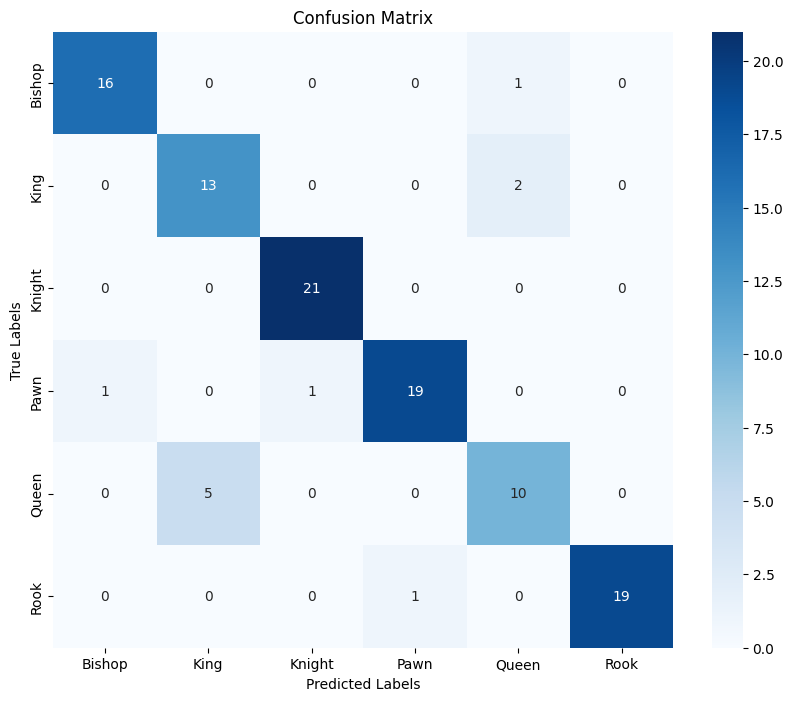

0.8990825688073395

In [ ]:
evaluate_model(model, val_ds)

#### Parameter tuning

#### Learning rate

In [ ]:
scores = {}

for lr in [0.00005, 0.0001, 0.001, 0.01]:

  print(lr)

  lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


  model = create_vgg19_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=lr, dropout_rate=0.3)
  model.summary()

  history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[lr_scheduler]
  )


  scores[lr] = history.history

  print()
  print()

5e-05


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,290,118 (77.40 MB)

 Trainable params: 7,345,158 (28.02 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 548ms/step - accuracy: 0.1893 - loss: 1.8753 - val_accuracy: 0.3945 - val_loss: 1.6746 - learning_rate: 5.0000e-05
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 415ms/step - accuracy: 0.2861 - loss: 1.7164 - val_accuracy: 0.5963 - val_loss: 1.2514 - learning_rate: 5.0000e-05
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 341ms/step - accuracy: 0.4955 - loss: 1.3665 - val_accuracy: 0.7890 - val_loss: 0.9399 - learning_rate: 5.0000e-05
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 313ms/step - accuracy: 0.6275 - loss: 1.0559 - val_accuracy: 0.7798 - val_loss: 0.6323 - learning_rate: 5.0000e-05
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 434ms/step - accuracy: 0.6548 - loss: 0.9470 - val_accuracy: 0.7248 - val_loss: 0.6829 - learning_rate: 5.0000e-05
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 310ms/step - accuracy: 0.7197 - loss: 0.7958 - val_accuracy: 0.8899 - val_loss: 0.4170 - learning_rate: 5.0000e-05
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 426ms/step - accurac

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,290,118 (77.40 MB)

 Trainable params: 7,345,158 (28.02 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 753ms/step - accuracy: 0.2611 - loss: 1.8297 - val_accuracy: 0.6606 - val_loss: 1.2757 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 376ms/step - accuracy: 0.4703 - loss: 1.3645 - val_accuracy: 0.6147 - val_loss: 0.9153 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 394ms/step - accuracy: 0.5987 - loss: 1.0810 - val_accuracy: 0.8257 - val_loss: 0.5586 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 352ms/step - accuracy: 0.6308 - loss: 0.8352 - val_accuracy: 0.7706 - val_loss: 0.5459 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 307ms/step - accuracy: 0.7702 - loss: 0.5999 - val_accuracy: 0.8073 - val_loss: 0.4529 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 365ms/step - accuracy: 0.7647 - loss: 0.5911 - val_accuracy: 0.8257 - val_loss: 0.4025 - learning_rate: 1.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 312ms/step - accur

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_10          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,290,118 (77.40 MB)

 Trainable params: 7,345,158 (28.02 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 654ms/step - accuracy: 0.1740 - loss: 1.9510 - val_accuracy: 0.1927 - val_loss: 1.9237 - learning_rate: 0.0010
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 324ms/step - accuracy: 0.2076 - loss: 1.8678 - val_accuracy: 0.1835 - val_loss: 1.7895 - learning_rate: 0.0010
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 390ms/step - accuracy: 0.2046 - loss: 1.8720 - val_accuracy: 0.1835 - val_loss: 1.7880 - learning_rate: 0.0010
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 319ms/step - accuracy: 0.1667 - loss: 1.7902 - val_accuracy: 0.1835 - val_loss: 1.7867 - learning_rate: 0.0010
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 344ms/step - accuracy: 0.2026 - loss: 1.7853 - val_accuracy: 0.1835 - val_loss: 1.7851 - learning_rate: 0.0010
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 313ms/step - accuracy: 0.1984 - loss: 1.7841 - val_accuracy: 0.1835 - val_loss: 1.7841 - learning_rate: 0.0010
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - accuracy: 0.1820 - loss: 1.78

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_11          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,290,118 (77.40 MB)

 Trainable params: 7,345,158 (28.02 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 609ms/step - accuracy: 0.1879 - loss: 733.1095 - val_accuracy: 0.1560 - val_loss: 1.8315 - learning_rate: 0.0100
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 303ms/step - accuracy: 0.1757 - loss: 1.8516 - val_accuracy: 0.1835 - val_loss: 1.7851 - learning_rate: 0.0100
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 305ms/step - accuracy: 0.1720 - loss: 1.8061 - val_accuracy: 0.1835 - val_loss: 1.7866 - learning_rate: 0.0100
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 317ms/step - accuracy: 0.1736 - loss: 1.7916 - val_accuracy: 0.1835 - val_loss: 1.7828 - learning_rate: 0.0100
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 421ms/step - accuracy: 0.2044 - loss: 1.7899 - val_accuracy: 0.1927 - val_loss: 1.7818 - learning_rate: 0.0100
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 313ms/step - accuracy: 0.1862 - loss: 1.7855 - val_accuracy: 0.1927 - val_loss: 1.7817 - learning_rate: 0.0100
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 411ms/step - accuracy: 0.2269 - loss: 1.8

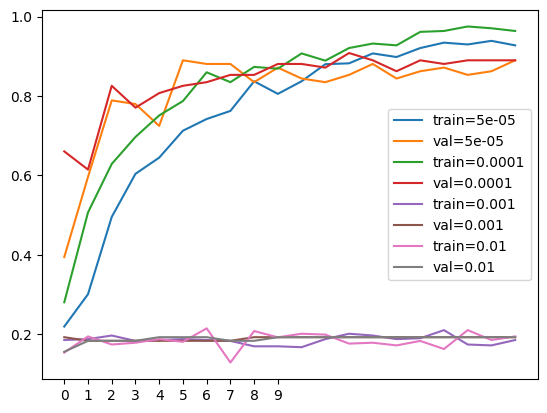

In [ ]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [ ]:
del scores[0.001]

del scores[0.01]



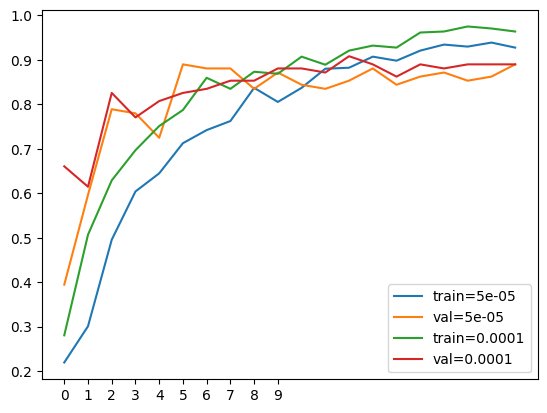

In [ ]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

**learning rate = 0.0001**

#### Dropout

In [ ]:
scores = {}

for do in [0.2, 0.3, 0.4, 0.5]:

  print(do)

  lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


  model = create_vgg19_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.0001, dropout_rate=do)
  model.summary()

  history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[lr_scheduler]
  )


  scores[do] = history.history

  print()
  print()

0.2


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_12          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,290,118 (77.40 MB)

 Trainable params: 7,345,158 (28.02 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 637ms/step - accuracy: 0.2273 - loss: 1.8017 - val_accuracy: 0.5872 - val_loss: 1.1991 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 313ms/step - accuracy: 0.5311 - loss: 1.3042 - val_accuracy: 0.6606 - val_loss: 0.9474 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 313ms/step - accuracy: 0.6317 - loss: 0.9782 - val_accuracy: 0.8349 - val_loss: 0.5053 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 356ms/step - accuracy: 0.7292 - loss: 0.6970 - val_accuracy: 0.8807 - val_loss: 0.3453 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 320ms/step - accuracy: 0.8090 - loss: 0.5252 - val_accuracy: 0.9083 - val_loss: 0.2788 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 307ms/step - accuracy: 0.8205 - loss: 0.4441 - val_accuracy: 0.8716 - val_loss: 0.2802 - learning_rate: 1.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 354ms/step - accurac

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_13          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,290,118 (77.40 MB)

 Trainable params: 7,345,158 (28.02 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 555ms/step - accuracy: 0.1892 - loss: 1.9460 - val_accuracy: 0.5505 - val_loss: 1.4252 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 391ms/step - accuracy: 0.3903 - loss: 1.5269 - val_accuracy: 0.6881 - val_loss: 0.9320 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step - accuracy: 0.5932 - loss: 1.0833 - val_accuracy: 0.8257 - val_loss: 0.5438 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 425ms/step - accuracy: 0.7068 - loss: 0.8517 - val_accuracy: 0.8073 - val_loss: 0.4361 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 327ms/step - accuracy: 0.7704 - loss: 0.6042 - val_accuracy: 0.8716 - val_loss: 0.3482 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 356ms/step - accuracy: 0.7886 - loss: 0.5914 - val_accuracy: 0.8073 - val_loss: 0.4875 - learning_rate: 1.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 391ms/step - accuracy

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_14          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,290,118 (77.40 MB)

 Trainable params: 7,345,158 (28.02 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 629ms/step - accuracy: 0.2137 - loss: 1.9901 - val_accuracy: 0.5046 - val_loss: 1.5344 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 382ms/step - accuracy: 0.3297 - loss: 1.6158 - val_accuracy: 0.5780 - val_loss: 1.1308 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 345ms/step - accuracy: 0.4625 - loss: 1.3334 - val_accuracy: 0.6239 - val_loss: 0.8591 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 326ms/step - accuracy: 0.5537 - loss: 1.1727 - val_accuracy: 0.7706 - val_loss: 0.6568 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 394ms/step - accuracy: 0.6421 - loss: 0.9294 - val_accuracy: 0.8440 - val_loss: 0.4298 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 316ms/step - accuracy: 0.7076 - loss: 0.6883 - val_accuracy: 0.8624 - val_loss: 0.3491 - learning_rate: 1.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 300ms/step - accuracy:

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_15          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,290,118 (77.40 MB)

 Trainable params: 7,345,158 (28.02 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 794ms/step - accuracy: 0.1974 - loss: 1.9147 - val_accuracy: 0.5046 - val_loss: 1.6071 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 318ms/step - accuracy: 0.2814 - loss: 1.7238 - val_accuracy: 0.6972 - val_loss: 1.1810 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 333ms/step - accuracy: 0.4280 - loss: 1.4431 - val_accuracy: 0.6972 - val_loss: 0.8481 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 477ms/step - accuracy: 0.5055 - loss: 1.2272 - val_accuracy: 0.7339 - val_loss: 0.6630 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 398ms/step - accuracy: 0.6059 - loss: 1.0331 - val_accuracy: 0.8257 - val_loss: 0.5121 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 315ms/step - accuracy: 0.6949 - loss: 0.8231 - val_accuracy: 0.8165 - val_loss: 0.4431 - learning_rate: 1.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - accurac

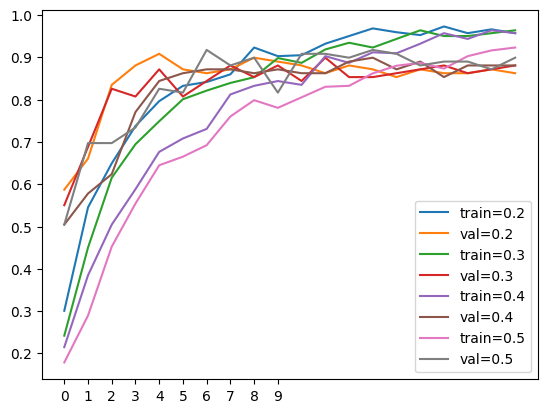

In [ ]:
for do, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % do))
    plt.plot(hist['val_accuracy'], label=('val=%s' % do))

plt.xticks(np.arange(10))
plt.legend()

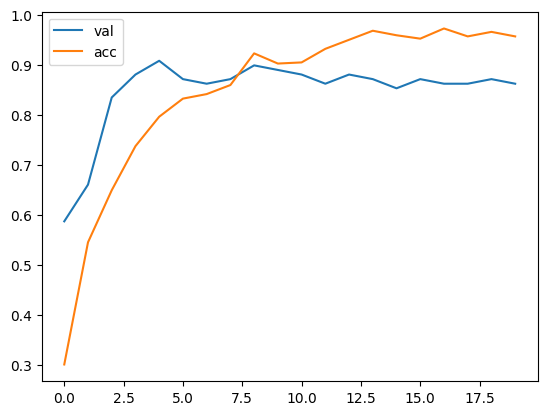

In [ ]:
hist = scores[0.2]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

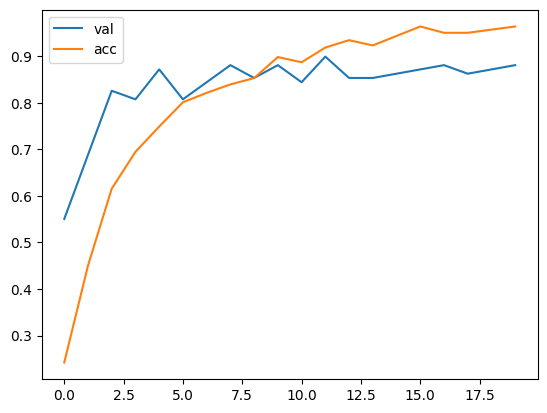

In [ ]:
hist = scores[0.3]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

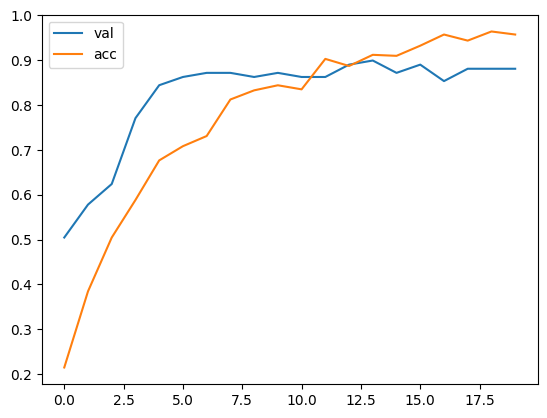

In [ ]:
hist = scores[0.4]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

**droprate = 0.4**

#### Finetuning number of layers in base model

In [ ]:
def create_vgg19_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.001, dropout_rate=0.5, freeze_layers = 4):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model
    base_model.trainable = True

    # Freeze all layers except the last few (to fine-tune only the last layers)
    for layer in base_model.layers[:-freeze_layers]:  # Unfreeze the last k layers
        layer.trainable = False

    model = models.Sequential([
        base_model,  # Add VGG19 as base model (without top layer)
        layers.GlobalAveragePooling2D(),  # Pooling layer to reduce spatial dimensions
        layers.Dropout(dropout_rate),  # Add dropout layer after pooling for regularization
        layers.Dense(512, activation='relu'),  # Fully connected layer with ReLU activation
        layers.Dropout(dropout_rate),  # Dropout after the dense layer
        layers.Dense(num_classes, activation='softmax')  # Output layer with softmax for classification
    ])

    # Compile the model with custom learning rate
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),  # Set the learning rate here
        loss='categorical_crossentropy',  # Multi-class classification
        metrics=['accuracy']
    )

    return model


In [ ]:
scores = {}

for layer in [4, 6, 8, 10]:

  print(layer)

  lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


  model = create_vgg19_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.0001, dropout_rate= 0.4, freeze_layers = layer)
  model.summary()

  history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[lr_scheduler]
  )


  scores[layer] = history.history

  print()
  print()

4


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,290,118 (77.40 MB)

 Trainable params: 7,345,158 (28.02 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2105 - loss: 1.9960 - val_accuracy: 0.5413 - val_loss: 1.5416 - learning_rate: 1.0000e-04
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 316ms/step - accuracy: 0.3297 - loss: 1.6219 - val_accuracy: 0.6972 - val_loss: 1.0170 - learning_rate: 1.0000e-04
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 396ms/step - accuracy: 0.5282 - loss: 1.2432 - val_accuracy: 0.7615 - val_loss: 0.6929 - learning_rate: 1.0000e-04
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 351ms/step - accuracy: 0.6077 - loss: 1.0329 - val_accuracy: 0.8532 - val_loss: 0.4917 - learning_rate: 1.0000e-04
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 321ms/step - accuracy: 0.7261 - loss: 0.7231 - val_accuracy: 0.8716 - val_loss: 0.3789 - learning_rate: 1.0000e-04
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 325ms/step - accuracy: 0.7635 - loss: 0.6992 - val_accuracy: 0.8349 - val_loss: 0.3574 - learning_rate: 1.0000e-04
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 410ms/step - accuracy: 0.8213 - l

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,290,118 (77.40 MB)

 Trainable params: 9,704,966 (37.02 MB)

 Non-trainable params: 10,585,152 (40.38 MB)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 571ms/step - accuracy: 0.1819 - loss: 2.0069 - val_accuracy: 0.4404 - val_loss: 1.5736 - learning_rate: 1.0000e-04
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 370ms/step - accuracy: 0.3416 - loss: 1.5872 - val_accuracy: 0.5413 - val_loss: 1.1662 - learning_rate: 1.0000e-04
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 338ms/step - accuracy: 0.5007 - loss: 1.3330 - val_accuracy: 0.6881 - val_loss: 0.7528 - learning_rate: 1.0000e-04
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 339ms/step - accuracy: 0.6265 - loss: 1.0249 - val_accuracy: 0.7615 - val_loss: 0.5812 - learning_rate: 1.0000e-04
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 366ms/step - accuracy: 0.6435 - loss: 0.8794 - val_accuracy: 0.8165 - val_loss: 0.4314 - learning_rate: 1.0000e-04
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 321ms/step - accuracy: 0.7514 - loss: 0.6678 - val_accuracy: 0.8532 - val_loss: 0.4043 - learning_rate: 1.0000e-04
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 402ms/step - accurac

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,290,118 (77.40 MB)

 Trainable params: 14,424,582 (55.03 MB)

 Non-trainable params: 5,865,536 (22.38 MB)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 899ms/step - accuracy: 0.2125 - loss: 1.9315 - val_accuracy: 0.1835 - val_loss: 1.7665 - learning_rate: 1.0000e-04
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 415ms/step - accuracy: 0.1645 - loss: 1.8344 - val_accuracy: 0.2569 - val_loss: 1.7311 - learning_rate: 1.0000e-04
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - accuracy: 0.2121 - loss: 1.7516 - val_accuracy: 0.4037 - val_loss: 1.5752 - learning_rate: 1.0000e-04
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 425ms/step - accuracy: 0.3530 - loss: 1.5873 - val_accuracy: 0.4771 - val_loss: 1.3751 - learning_rate: 1.0000e-04
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 590ms/step - accuracy: 0.3646 - loss: 1.5789 - val_accuracy: 0.2385 - val_loss: 1.5893 - learning_rate: 1.0000e-04
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 341ms/step - accuracy: 0.2055 - loss: 1.7063 - val_accuracy: 0.3211 - val_loss: 1.5130 - learning_rate: 1.0000e-04
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 340ms/step - accurac

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,290,118 (77.40 MB)

 Trainable params: 17,964,550 (68.53 MB)

 Non-trainable params: 2,325,568 (8.87 MB)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 845ms/step - accuracy: 0.1543 - loss: 1.9377 - val_accuracy: 0.2294 - val_loss: 1.7888 - learning_rate: 1.0000e-04
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 411ms/step - accuracy: 0.2023 - loss: 1.7902 - val_accuracy: 0.1376 - val_loss: 1.7952 - learning_rate: 1.0000e-04
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 484ms/step - accuracy: 0.1697 - loss: 1.7948 - val_accuracy: 0.2110 - val_loss: 1.7900 - learning_rate: 1.0000e-04
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 407ms/step - accuracy: 0.1757 - loss: 1.7864 - val_accuracy: 0.1927 - val_loss: 1.7850 - learning_rate: 1.0000e-04
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 360ms/step - accuracy: 0.1687 - loss: 1.7865 - val_accuracy: 0.1927 - val_loss: 1.7838 - learning_rate: 1.0000e-04
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 430ms/step - accuracy: 0.2099 - loss: 1.7807 - val_accuracy: 0.1743 - val_loss: 1.7858 - learning_rate: 1.0000e-04
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 409ms/step - accura

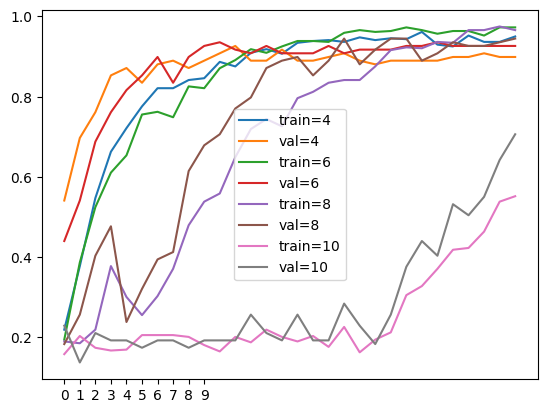

In [ ]:
for layer, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % layer))
    plt.plot(hist['val_accuracy'], label=('val=%s' % layer))

plt.xticks(np.arange(10))
plt.legend()

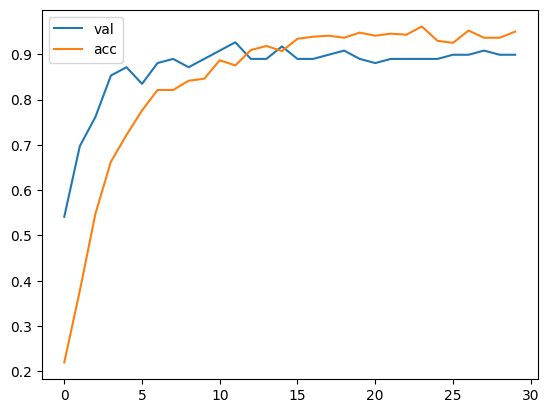

In [ ]:
hist = scores[4]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

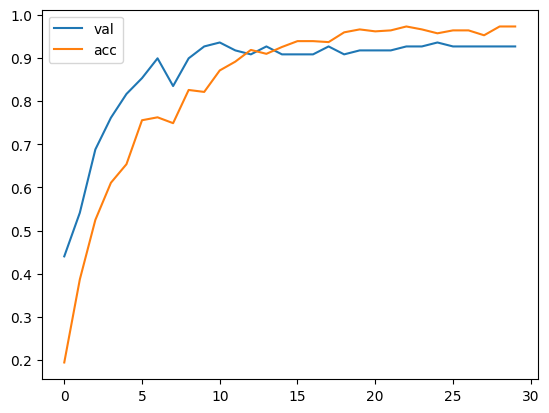

In [ ]:
hist = scores[6]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

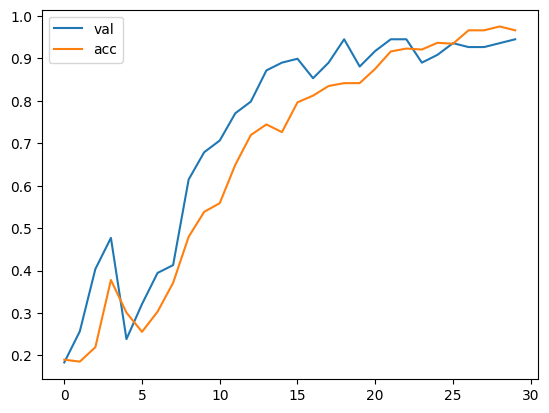

In [ ]:
hist = scores[8]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

**Finetuning_layers=8**

In [ ]:
model = create_vgg19_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.0001, dropout_rate= 0.4, freeze_layers = 8)
model.summary()

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[lr_scheduler]
  )


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,290,118 (77.40 MB)

 Trainable params: 14,424,582 (55.03 MB)

 Non-trainable params: 5,865,536 (22.38 MB)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 587ms/step - accuracy: 0.1797 - loss: 1.9566 - val_accuracy: 0.2477 - val_loss: 1.6741 - learning_rate: 1.0000e-04
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 374ms/step - accuracy: 0.2040 - loss: 1.7844 - val_accuracy: 0.2569 - val_loss: 1.7621 - learning_rate: 1.0000e-04
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 393ms/step - accuracy: 0.2545 - loss: 1.7738 - val_accuracy: 0.3486 - val_loss: 1.6744 - learning_rate: 1.0000e-04
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 332ms/step - accuracy: 0.2350 - loss: 1.7396 - val_accuracy: 0.4954 - val_loss: 1.3964 - learning_rate: 1.0000e-04
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 337ms/step - accuracy: 0.4022 - loss: 1.4874 - val_accuracy: 0.5505 - val_loss: 1.0681 - learning_rate: 1.0000e-04
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 339ms/step - accuracy: 0.5056 - loss: 1.2399 - val_accuracy: 0.6789 - val_loss: 1.0236 - learning_rate: 1.0000e-04
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 381ms/step - accura

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step
Validation Accuracy: 93.58%


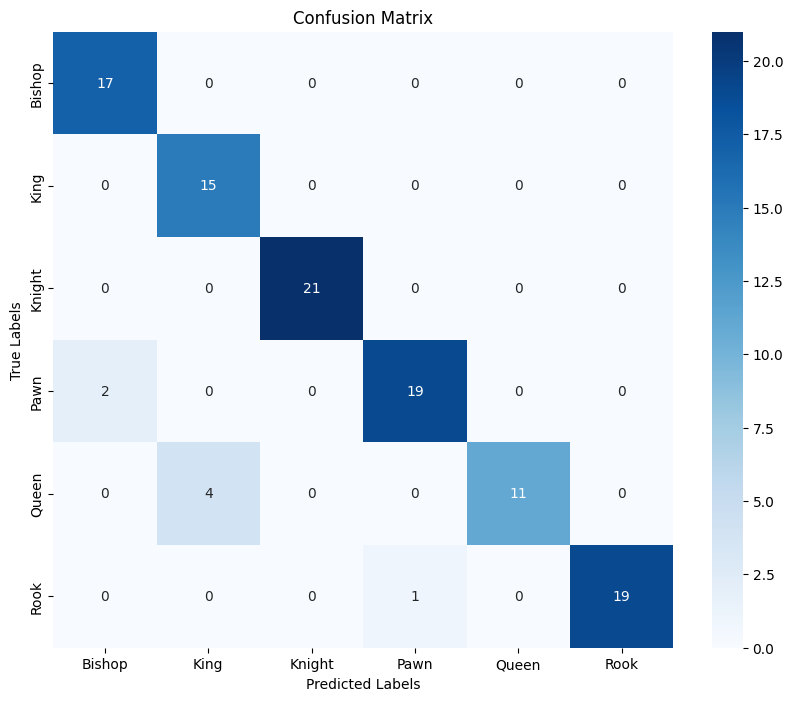

0.9357798165137615

In [ ]:
evaluate_model(model, val_ds)

### MobileNet Model

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


def create_mobilenet_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.001, dropout_rate=0.4):
    # Load the pre-trained MobileNet model
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model
    base_model.trainable = True
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    # Add custom layers on top
    model = models.Sequential([
        base_model,  # Add the MobileNet base model
        layers.GlobalAveragePooling2D(),  # Pooling layer to reduce spatial dimensions
        layers.Dropout(dropout_rate),  # Add dropout for regularization
        layers.Dense(256, activation='relu'),  # Fully connected layer
        layers.Dropout(dropout_rate),  # Another dropout layer
        layers.Dense(num_classes, activation='softmax')  # Output layer for classification
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class tasks
        metrics=['accuracy']
    )

    return model




In [ ]:
# Create the MobileNet model
model = create_mobilenet_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.0001, dropout_rate=0.2)

# Print model summary
model.summary()

<ipython-input-20-875da3af9699>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,492,806 (13.32 MB)

 Trainable params: 1,314,566 (5.01 MB)

 Non-trainable params: 2,178,240 (8.31 MB)

In [ ]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


history = model.fit(
    train_ds,  # Replace with your training dataset
    validation_data=val_ds,  # Replace with your validation dataset
    epochs=20,
    callbacks=[lr_scheduler]  # Optional learning rate scheduler
)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 768ms/step - accuracy: 0.1726 - loss: 2.5921 - val_accuracy: 0.2936 - val_loss: 1.7843 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 348ms/step - accuracy: 0.3850 - loss: 1.6929 - val_accuracy: 0.3853 - val_loss: 1.6233 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step - accuracy: 0.5118 - loss: 1.2618 - val_accuracy: 0.4312 - val_loss: 1.4572 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 268ms/step - accuracy: 0.5615 - loss: 1.1239 - val_accuracy: 0.5046 - val_loss: 1.3782 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 369ms/step - accuracy: 0.6633 - loss: 0.9243 - val_accuracy: 0.5596 - val_loss: 1.2059 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.6548 - loss: 0.9203 - val_accuracy: 0.6422 - val_loss: 0.9815 - learning_rate: 1.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 358ms/step - accurac

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 680ms/step
Validation Accuracy: 84.40%


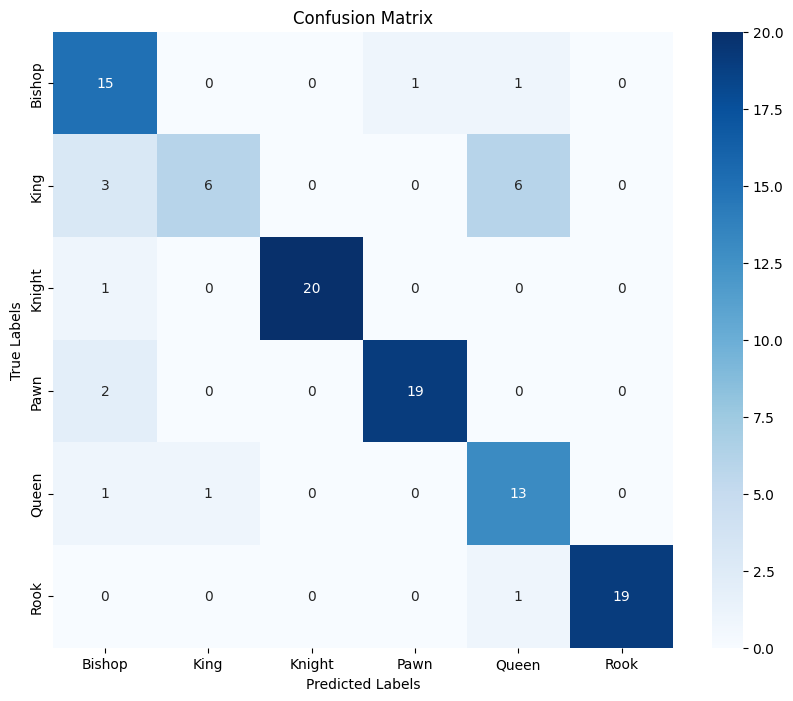

0.8440366972477065

In [ ]:
evaluate_model(model, val_ds)

#### Parameter tuning

#### Learning rate

In [ ]:
scores = {}

for lr in [0.00005, 0.0001, 0.001, 0.01]:

  print(lr)

  lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


  model = create_mobilenet_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=lr, dropout_rate=0.2)
  model.summary()

  history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[lr_scheduler]
  )


  scores[lr] = history.history

  print()
  print()

5e-05


<ipython-input-20-875da3af9699>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,492,806 (13.32 MB)

 Trainable params: 1,314,566 (5.01 MB)

 Non-trainable params: 2,178,240 (8.31 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 705ms/step - accuracy: 0.2052 - loss: 2.5368 - val_accuracy: 0.2385 - val_loss: 2.2347 - learning_rate: 5.0000e-05
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 285ms/step - accuracy: 0.3114 - loss: 1.8988 - val_accuracy: 0.3028 - val_loss: 1.9604 - learning_rate: 5.0000e-05
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 313ms/step - accuracy: 0.3481 - loss: 1.7157 - val_accuracy: 0.3853 - val_loss: 1.7602 - learning_rate: 5.0000e-05
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 332ms/step - accuracy: 0.4359 - loss: 1.5112 - val_accuracy: 0.4128 - val_loss: 1.5926 - learning_rate: 5.0000e-05
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step - accuracy: 0.4806 - loss: 1.4113 - val_accuracy: 0.4771 - val_loss: 1.3867 - learning_rate: 5.0000e-05
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 257ms/step - accuracy: 0.5003 - loss: 1.2207 - val_accuracy: 0.5872 - val_loss: 1.2190 - learning_rate: 5.0000e-05
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - accur

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,492,806 (13.32 MB)

 Trainable params: 1,314,566 (5.01 MB)

 Non-trainable params: 2,178,240 (8.31 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 728ms/step - accuracy: 0.1885 - loss: 2.4888 - val_accuracy: 0.2202 - val_loss: 2.2962 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 397ms/step - accuracy: 0.4081 - loss: 1.6558 - val_accuracy: 0.3945 - val_loss: 1.9114 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 369ms/step - accuracy: 0.4391 - loss: 1.4156 - val_accuracy: 0.4587 - val_loss: 1.5902 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step - accuracy: 0.6087 - loss: 1.0690 - val_accuracy: 0.4862 - val_loss: 1.3342 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 327ms/step - accuracy: 0.6901 - loss: 0.9146 - val_accuracy: 0.5780 - val_loss: 1.1238 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.6820 - loss: 0.8821 - val_accuracy: 0.6239 - val_loss: 0.9831 - learning_rate: 1.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 291ms/step - accurac

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,492,806 (13.32 MB)

 Trainable params: 1,314,566 (5.01 MB)

 Non-trainable params: 2,178,240 (8.31 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 610ms/step - accuracy: 0.3303 - loss: 2.6190 - val_accuracy: 0.2844 - val_loss: 4.1797 - learning_rate: 0.0010
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 257ms/step - accuracy: 0.7017 - loss: 0.8829 - val_accuracy: 0.5505 - val_loss: 1.6415 - learning_rate: 0.0010
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - accuracy: 0.7999 - loss: 0.5237 - val_accuracy: 0.4037 - val_loss: 2.4126 - learning_rate: 0.0010
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 330ms/step - accuracy: 0.8466 - loss: 0.4027 - val_accuracy: 0.4954 - val_loss: 1.8079 - learning_rate: 0.0010
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step - accuracy: 0.8695 - loss: 0.3302 - val_accuracy: 0.7431 - val_loss: 0.9791 - learning_rate: 0.0010
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - accuracy: 0.9181 - loss: 0.2773 - val_accuracy: 0.6972 - val_loss: 0.9371 - learning_rate: 0.0010
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 286ms/step - accuracy: 0.9222 - loss: 0.258

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,492,806 (13.32 MB)

 Trainable params: 1,314,566 (5.01 MB)

 Non-trainable params: 2,178,240 (8.31 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 675ms/step - accuracy: 0.2982 - loss: 7.3491 - val_accuracy: 0.3119 - val_loss: 2.9471 - learning_rate: 0.0100
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 251ms/step - accuracy: 0.6072 - loss: 0.9837 - val_accuracy: 0.2294 - val_loss: 3.1045 - learning_rate: 0.0100
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.6372 - loss: 0.9755 - val_accuracy: 0.3578 - val_loss: 2.9670 - learning_rate: 0.0100
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.6744 - loss: 0.7579 - val_accuracy: 0.5688 - val_loss: 1.4736 - learning_rate: 0.0100
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 359ms/step - accuracy: 0.7483 - loss: 0.6342 - val_accuracy: 0.3486 - val_loss: 2.9935 - learning_rate: 0.0100
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 320ms/step - accuracy: 0.7732 - loss: 0.5831 - val_accuracy: 0.5780 - val_loss: 1.4848 - learning_rate: 0.0100
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step - accuracy: 0.7620 - loss: 0.569

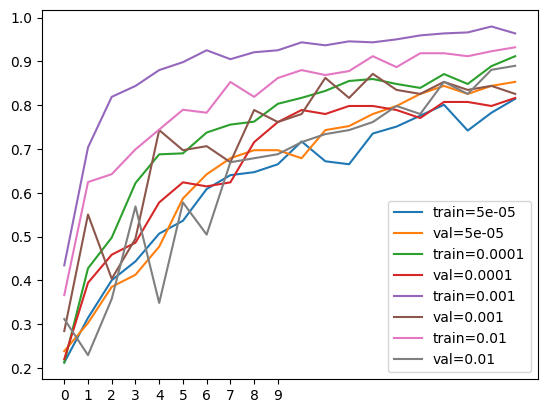

In [ ]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [ ]:
del scores[0.001]

del scores[0.01]

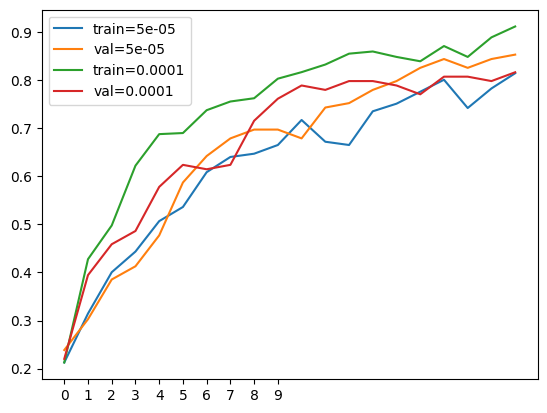

In [ ]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

**learning rate = 0.0001**

#### Dropout

In [ ]:
scores = {}

for do in [0.2, 0.3, 0.4, 0.5]:

  print(do)

  lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


  model = create_mobilenet_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.0001, dropout_rate=do)
  model.summary()

  history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[lr_scheduler]
  )


  scores[do] = history.history

  print()
  print()

0.2


<ipython-input-20-875da3af9699>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,492,806 (13.32 MB)

 Trainable params: 1,314,566 (5.01 MB)

 Non-trainable params: 2,178,240 (8.31 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 649ms/step - accuracy: 0.2040 - loss: 2.7598 - val_accuracy: 0.2110 - val_loss: 2.0111 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 362ms/step - accuracy: 0.3997 - loss: 1.6382 - val_accuracy: 0.3028 - val_loss: 1.9314 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step - accuracy: 0.5133 - loss: 1.3694 - val_accuracy: 0.3670 - val_loss: 1.9451 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 336ms/step - accuracy: 0.5707 - loss: 1.1340 - val_accuracy: 0.4220 - val_loss: 1.7591 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - accuracy: 0.6327 - loss: 0.9032 - val_accuracy: 0.5413 - val_loss: 1.2741 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 255ms/step - accuracy: 0.6955 - loss: 0.8795 - val_accuracy: 0.5963 - val_loss: 1.0443 - learning_rate: 1.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 259ms/step - accura

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,492,806 (13.32 MB)

 Trainable params: 1,314,566 (5.01 MB)

 Non-trainable params: 2,178,240 (8.31 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 821ms/step - accuracy: 0.2162 - loss: 2.5906 - val_accuracy: 0.2569 - val_loss: 1.9723 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 357ms/step - accuracy: 0.3107 - loss: 1.9873 - val_accuracy: 0.3303 - val_loss: 1.8119 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - accuracy: 0.4598 - loss: 1.6187 - val_accuracy: 0.3945 - val_loss: 1.6072 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 344ms/step - accuracy: 0.4581 - loss: 1.4896 - val_accuracy: 0.4404 - val_loss: 1.4227 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 287ms/step - accuracy: 0.5489 - loss: 1.1803 - val_accuracy: 0.4862 - val_loss: 1.3171 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - accuracy: 0.6529 - loss: 0.9237 - val_accuracy: 0.5505 - val_loss: 1.0960 - learning_rate: 1.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - accurac

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_10          │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,492,806 (13.32 MB)

 Trainable params: 1,314,566 (5.01 MB)

 Non-trainable params: 2,178,240 (8.31 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 728ms/step - accuracy: 0.1779 - loss: 3.1168 - val_accuracy: 0.3119 - val_loss: 1.7465 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 340ms/step - accuracy: 0.2722 - loss: 2.2039 - val_accuracy: 0.4495 - val_loss: 1.4856 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.3114 - loss: 2.0978 - val_accuracy: 0.4862 - val_loss: 1.3311 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step - accuracy: 0.4285 - loss: 1.7038 - val_accuracy: 0.5505 - val_loss: 1.1746 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 389ms/step - accuracy: 0.4407 - loss: 1.6944 - val_accuracy: 0.5688 - val_loss: 1.0872 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 0.5513 - loss: 1.4062 - val_accuracy: 0.6055 - val_loss: 0.9707 - learning_rate: 1.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 246ms/step - accurac

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_11          │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,492,806 (13.32 MB)

 Trainable params: 1,314,566 (5.01 MB)

 Non-trainable params: 2,178,240 (8.31 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 760ms/step - accuracy: 0.1542 - loss: 4.0120 - val_accuracy: 0.2936 - val_loss: 1.9164 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.2438 - loss: 3.0477 - val_accuracy: 0.4220 - val_loss: 1.6854 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - accuracy: 0.2759 - loss: 2.6721 - val_accuracy: 0.4495 - val_loss: 1.5391 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 275ms/step - accuracy: 0.3292 - loss: 2.4185 - val_accuracy: 0.5229 - val_loss: 1.3980 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 369ms/step - accuracy: 0.3115 - loss: 2.1101 - val_accuracy: 0.5505 - val_loss: 1.2650 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step - accuracy: 0.4534 - loss: 1.7273 - val_accuracy: 0.6055 - val_loss: 1.1124 - learning_rate: 1.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accura

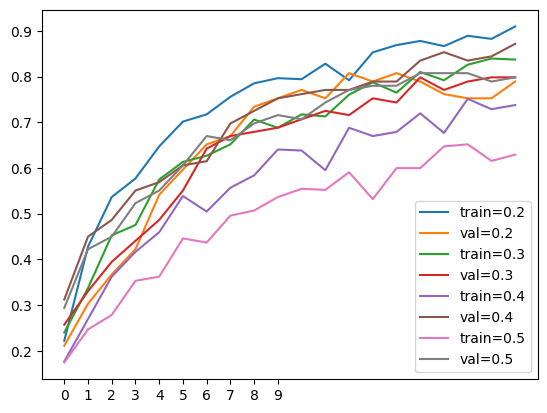

In [ ]:
for do, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % do))
    plt.plot(hist['val_accuracy'], label=('val=%s' % do))

plt.xticks(np.arange(10))
plt.legend()

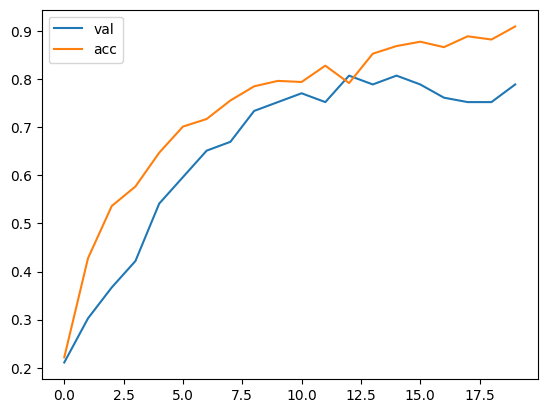

In [ ]:
hist = scores[0.2]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

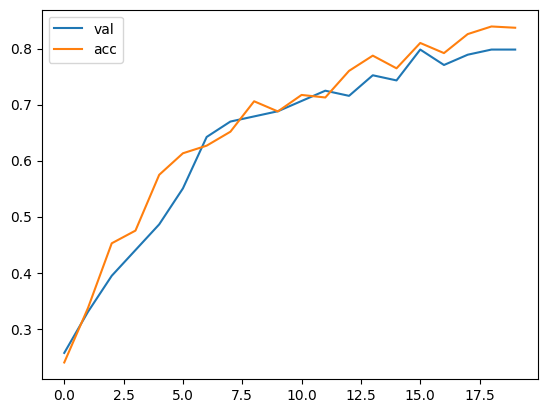

In [ ]:
hist = scores[0.3]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

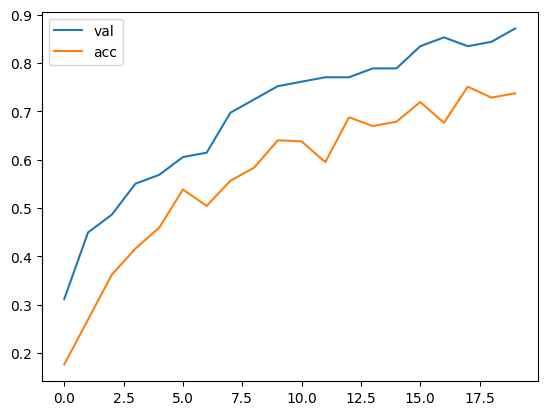

In [ ]:
hist = scores[0.4]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

**dropout=0.3**

#### Finetuning number of layers in base model

In [ ]:
def create_mobilenet_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.0001, dropout_rate=0.3, freeze_layers = 4):
    # Load the pre-trained MobileNet model
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model
    base_model.trainable = True
    for layer in base_model.layers[:-freeze_layers]:
        layer.trainable = False

    # Add custom layers on top
    model = models.Sequential([
        base_model,  # Add the MobileNet base model
        layers.GlobalAveragePooling2D(),  # Pooling layer to reduce spatial dimensions
        layers.Dropout(dropout_rate),  # Add dropout for regularization
        layers.Dense(256, activation='relu'),  # Fully connected layer
        layers.Dropout(dropout_rate),  # Another dropout layer
        layers.Dense(num_classes, activation='softmax')  # Output layer for classification
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class tasks
        metrics=['accuracy']
    )

    return model

In [ ]:
scores = {}

for layer in [4, 6, 8, 10]:

  print(layer)

  lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


  model = create_mobilenet_model(freeze_layers = layer)
  model.summary()

  history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[lr_scheduler]
  )


  scores[layer] = history.history

  print()
  print()

4


<ipython-input-33-901cd5d0d66d>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_12          │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,492,806 (13.32 MB)

 Trainable params: 1,314,566 (5.01 MB)

 Non-trainable params: 2,178,240 (8.31 MB)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 791ms/step - accuracy: 0.1532 - loss: 2.8835 - val_accuracy: 0.1376 - val_loss: 2.0716 - learning_rate: 1.0000e-04
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - accuracy: 0.2897 - loss: 2.1082 - val_accuracy: 0.2752 - val_loss: 1.9438 - learning_rate: 1.0000e-04
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - accuracy: 0.4145 - loss: 1.5826 - val_accuracy: 0.3670 - val_loss: 1.7052 - learning_rate: 1.0000e-04
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 319ms/step - accuracy: 0.4763 - loss: 1.4135 - val_accuracy: 0.4679 - val_loss: 1.4701 - learning_rate: 1.0000e-04
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step - accuracy: 0.5701 - loss: 1.1927 - val_accuracy: 0.5596 - val_loss: 1.2834 - learning_rate: 1.0000e-04
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 268ms/step - accuracy: 0.6231 - loss: 1.0774 - val_accuracy: 0.6055 - val_loss: 1.1968 - learning_rate: 1.0000e-04
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 354ms/step - accuracy

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_13          │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,492,806 (13.32 MB)

 Trainable params: 1,325,830 (5.06 MB)

 Non-trainable params: 2,166,976 (8.27 MB)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 807ms/step - accuracy: 0.1552 - loss: 3.2028 - val_accuracy: 0.2294 - val_loss: 1.9781 - learning_rate: 1.0000e-04
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 287ms/step - accuracy: 0.3357 - loss: 2.0559 - val_accuracy: 0.3119 - val_loss: 1.8829 - learning_rate: 1.0000e-04
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 271ms/step - accuracy: 0.4288 - loss: 1.6247 - val_accuracy: 0.3578 - val_loss: 1.8117 - learning_rate: 1.0000e-04
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 354ms/step - accuracy: 0.5180 - loss: 1.3521 - val_accuracy: 0.4312 - val_loss: 1.6099 - learning_rate: 1.0000e-04
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 285ms/step - accuracy: 0.5191 - loss: 1.2802 - val_accuracy: 0.4771 - val_loss: 1.4149 - learning_rate: 1.0000e-04
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 252ms/step - accuracy: 0.5814 - loss: 1.1302 - val_accuracy: 0.4954 - val_loss: 1.3259 - learning_rate: 1.0000e-04
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 329ms/step - accurac

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_14          │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,492,806 (13.32 MB)

 Trainable params: 1,327,878 (5.07 MB)

 Non-trainable params: 2,164,928 (8.26 MB)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 694ms/step - accuracy: 0.1977 - loss: 2.9419 - val_accuracy: 0.2661 - val_loss: 1.9473 - learning_rate: 1.0000e-04
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 288ms/step - accuracy: 0.2763 - loss: 2.1461 - val_accuracy: 0.3486 - val_loss: 1.6192 - learning_rate: 1.0000e-04
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 362ms/step - accuracy: 0.3988 - loss: 1.7655 - val_accuracy: 0.4771 - val_loss: 1.4647 - learning_rate: 1.0000e-04
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 327ms/step - accuracy: 0.5031 - loss: 1.4945 - val_accuracy: 0.4771 - val_loss: 1.3770 - learning_rate: 1.0000e-04
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 287ms/step - accuracy: 0.5783 - loss: 1.2089 - val_accuracy: 0.5321 - val_loss: 1.2245 - learning_rate: 1.0000e-04
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 258ms/step - accuracy: 0.6258 - loss: 1.1315 - val_accuracy: 0.5688 - val_loss: 1.0842 - learning_rate: 1.0000e-04
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 303ms/step - accura

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_15          │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,492,806 (13.32 MB)

 Trainable params: 1,852,166 (7.07 MB)

 Non-trainable params: 1,640,640 (6.26 MB)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 885ms/step - accuracy: 0.2267 - loss: 2.7276 - val_accuracy: 0.3486 - val_loss: 1.8358 - learning_rate: 1.0000e-04
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - accuracy: 0.3756 - loss: 1.8568 - val_accuracy: 0.3303 - val_loss: 1.6847 - learning_rate: 1.0000e-04
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 327ms/step - accuracy: 0.5154 - loss: 1.4317 - val_accuracy: 0.4862 - val_loss: 1.4045 - learning_rate: 1.0000e-04
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.5725 - loss: 1.2867 - val_accuracy: 0.5688 - val_loss: 1.1138 - learning_rate: 1.0000e-04
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - accuracy: 0.6307 - loss: 0.9910 - val_accuracy: 0.6330 - val_loss: 0.9501 - learning_rate: 1.0000e-04
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 252ms/step - accuracy: 0.6680 - loss: 0.9026 - val_accuracy: 0.6697 - val_loss: 0.9099 - learning_rate: 1.0000e-04
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accurac

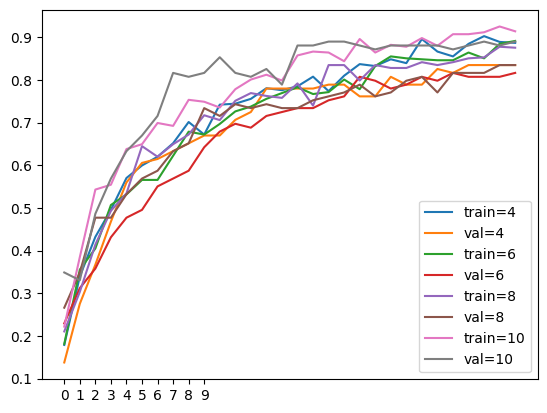

In [ ]:
for layer, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % layer))
    plt.plot(hist['val_accuracy'], label=('val=%s' % layer))

plt.xticks(np.arange(10))
plt.legend()

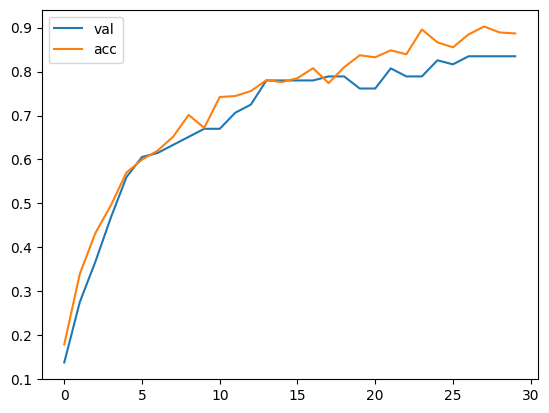

In [ ]:
hist = scores[4]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

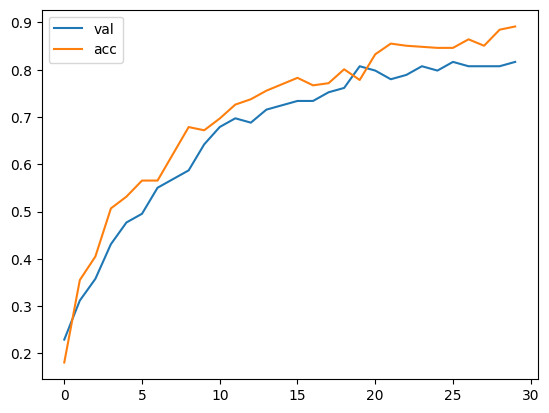

In [ ]:
hist = scores[6]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

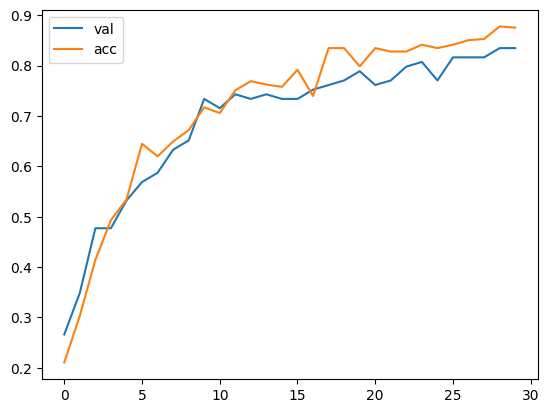

In [ ]:
hist = scores[8]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

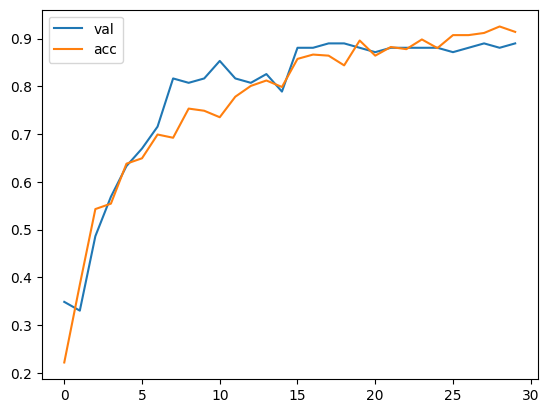

In [ ]:
hist = scores[10]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

**Finetuning_layers=10**

In [ ]:
model = create_mobilenet_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.0001, dropout_rate= 0.3, freeze_layers = 10)
model.summary()

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[lr_scheduler]
  )


<ipython-input-33-901cd5d0d66d>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_16          │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,492,806 (13.32 MB)

 Trainable params: 1,852,166 (7.07 MB)

 Non-trainable params: 1,640,640 (6.26 MB)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 791ms/step - accuracy: 0.1409 - loss: 3.1529 - val_accuracy: 0.2844 - val_loss: 1.8108 - learning_rate: 1.0000e-04
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step - accuracy: 0.3356 - loss: 2.0785 - val_accuracy: 0.3578 - val_loss: 1.4668 - learning_rate: 1.0000e-04
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.5018 - loss: 1.4629 - val_accuracy: 0.4220 - val_loss: 1.3487 - learning_rate: 1.0000e-04
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 265ms/step - accuracy: 0.5289 - loss: 1.2060 - val_accuracy: 0.4587 - val_loss: 1.2389 - learning_rate: 1.0000e-04
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 342ms/step - accuracy: 0.5960 - loss: 1.0177 - val_accuracy: 0.5596 - val_loss: 1.1059 - learning_rate: 1.0000e-04
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 360ms/step - accuracy: 0.6490 - loss: 0.9033 - val_accuracy: 0.5963 - val_loss: 0.9332 - learning_rate: 1.0000e-04
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 261ms/step - accura

In [ ]:
evaluate_model(model, val_ds)

In [ ]:
def create_mobilenet_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.0001, dropout_rate=0.3, freeze_layers = 4):
    # Load the pre-trained MobileNet model
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model
    base_model.trainable = True
    for layer in base_model.layers[:-freeze_layers]:
        layer.trainable = False

    # Add custom layers on top
    model = models.Sequential([
        base_model,  # Add the MobileNet base model
        layers.GlobalAveragePooling2D(),  # Pooling layer to reduce spatial dimensions
        layers.Dropout(dropout_rate),  # Add dropout for regularization
        layers.Dense(512, activation='relu'),  # Fully connected layer
        layers.Dropout(dropout_rate),  # Another dropout layer
        layers.Dense(num_classes, activation='softmax')  # Output layer for classification
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class tasks
        metrics=['accuracy']
    )

    return model

In [ ]:
model = create_mobilenet_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.0001, dropout_rate= 0.3, freeze_layers = 10)
model.summary()

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[lr_scheduler]
  )


<ipython-input-17-f7636ec0653f>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,756,742 (14.33 MB)

 Trainable params: 2,116,102 (8.07 MB)

 Non-trainable params: 1,640,640 (6.26 MB)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 984ms/step - accuracy: 0.2039 - loss: 2.5695 - val_accuracy: 0.2844 - val_loss: 1.7398 - learning_rate: 1.0000e-04
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 27s 395ms/step - accuracy: 0.3624 - loss: 1.8466 - val_accuracy: 0.3394 - val_loss: 1.7267 - learning_rate: 1.0000e-04
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 0.5314 - loss: 1.3343 - val_accuracy: 0.3670 - val_loss: 1.7254 - learning_rate: 1.0000e-04
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 378ms/step - accuracy: 0.5919 - loss: 1.1411 - val_accuracy: 0.4128 - val_loss: 1.5540 - learning_rate: 1.0000e-04
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 306ms/step - accuracy: 0.5869 - loss: 0.9790 - val_accuracy: 0.5505 - val_loss: 1.2079 - learning_rate: 1.0000e-04
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 282ms/step - accuracy: 0.6492 - loss: 0.9539 - val_accuracy: 0.6147 - val_loss: 0.9862 - learning_rate: 1.0000e-04
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 273ms/step - accuracy: 0.7193 

### ResNet50 Model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


def create_resnet50_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.001, dropout_rate=0.3, freeze_layers=10):
    # Load the pre-trained ResNet50 model without the top layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Set the base model to trainable
    base_model.trainable = True

    # Freeze the initial layers up to the freeze_layers index
    for layer in base_model.layers[:-freeze_layers]:
        layer.trainable = False

    # Add custom layers on top
    model = models.Sequential([
        base_model,  # Add the ResNet50 base model
        layers.GlobalAveragePooling2D(),  # Pooling layer to reduce spatial dimensions
        layers.Dropout(dropout_rate),  # Add dropout for regularization
        layers.Dense(512, activation='relu'),  # Fully connected layer
        layers.Dropout(dropout_rate),  # Another dropout layer
        layers.Dense(num_classes, activation='softmax')  # Output layer for classification
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class tasks
        metrics=['accuracy']
    )

    return model




In [ ]:
# Create the ResNet50 model
model = create_resnet50_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.0001, dropout_rate=0.2, freeze_layers=10)

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 5,517,830 (21.05 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [ ]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


history = model.fit(
    train_ds,  # Replace with your training dataset
    validation_data=val_ds,  # Replace with your validation dataset
    epochs=20,
    callbacks=[lr_scheduler]  # Optional learning rate scheduler
)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.1777 - loss: 1.9667 - val_accuracy: 0.1743 - val_loss: 1.8165 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 27s 376ms/step - accuracy: 0.2234 - loss: 1.7905 - val_accuracy: 0.1651 - val_loss: 1.7949 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 400ms/step - accuracy: 0.2544 - loss: 1.7498 - val_accuracy: 0.2385 - val_loss: 1.7671 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 381ms/step - accuracy: 0.2696 - loss: 1.6702 - val_accuracy: 0.2385 - val_loss: 1.7716 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step - accuracy: 0.3690 - loss: 1.6018 - val_accuracy: 0.2477 - val_loss: 1.7366 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 373ms/step - accuracy: 0.4166 - loss: 1.5021 - val_accuracy: 0.2752 - val_loss: 1.7073 - learning_rate: 1.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 342ms/step - accuracy: 0

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
Validation Accuracy: 54.13%


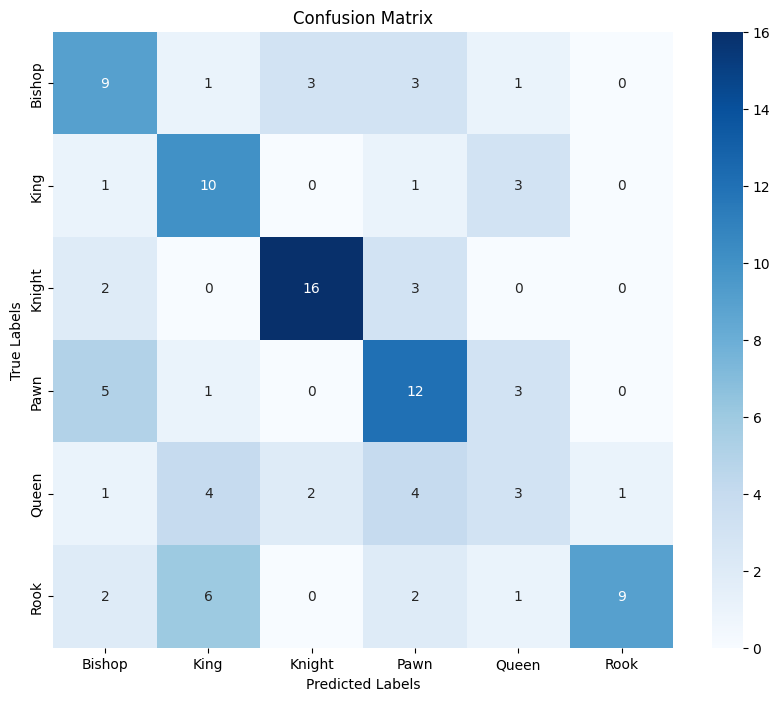

0.5412844036697247

In [ ]:
evaluate_model(model, val_ds)

#### Parameter tuning

#### Learning rate

In [ ]:
scores = {}

for lr in [0.00005, 0.0001, 0.001, 0.01]:

  print(lr)

  lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


  model = create_resnet50_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=lr, dropout_rate=0.2, freeze_layers=4)
  model.summary()

  history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[lr_scheduler]
  )


  scores[lr] = history.history

  print()
  print()

5e-05


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 2,106,886 (8.04 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.1659 - loss: 1.9130 - val_accuracy: 0.2385 - val_loss: 1.7669 - learning_rate: 5.0000e-05
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 378ms/step - accuracy: 0.2599 - loss: 1.7455 - val_accuracy: 0.2202 - val_loss: 1.7578 - learning_rate: 5.0000e-05
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.2467 - loss: 1.7295 - val_accuracy: 0.2018 - val_loss: 1.7545 - learning_rate: 5.0000e-05
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 303ms/step - accuracy: 0.2771 - loss: 1.7402 - val_accuracy: 0.2385 - val_loss: 1.7465 - learning_rate: 5.0000e-05
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.2673 - loss: 1.6841 - val_accuracy: 0.2936 - val_loss: 1.7379 - learning_rate: 5.0000e-05
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 317ms/step - accuracy: 0.2433 - loss: 1.6866 - val_accuracy: 0.2385 - val_loss: 1.7389 - learning_rate: 5.0000e-05
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 300ms/step - accuracy: 0.2661 - lo

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 2,106,886 (8.04 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.1809 - loss: 1.9671 - val_accuracy: 0.2385 - val_loss: 1.7764 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 396ms/step - accuracy: 0.1927 - loss: 1.8045 - val_accuracy: 0.2477 - val_loss: 1.7668 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 282ms/step - accuracy: 0.2699 - loss: 1.7276 - val_accuracy: 0.2385 - val_loss: 1.7556 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 394ms/step - accuracy: 0.2786 - loss: 1.7254 - val_accuracy: 0.2844 - val_loss: 1.7379 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 329ms/step - accuracy: 0.2940 - loss: 1.6876 - val_accuracy: 0.2844 - val_loss: 1.7398 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 291ms/step - accuracy: 0.3494 - loss: 1.5736 - val_accuracy: 0.3028 - val_loss: 1.7221 - learning_rate: 1.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 342ms/step - accuracy: 

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 2,106,886 (8.04 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.1879 - loss: 2.1903 - val_accuracy: 0.2110 - val_loss: 1.9005 - learning_rate: 0.0010
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 0.3144 - loss: 1.7275 - val_accuracy: 0.2294 - val_loss: 1.7885 - learning_rate: 0.0010
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 282ms/step - accuracy: 0.3042 - loss: 1.6996 - val_accuracy: 0.2294 - val_loss: 1.7487 - learning_rate: 0.0010
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 375ms/step - accuracy: 0.3358 - loss: 1.5576 - val_accuracy: 0.2936 - val_loss: 1.7640 - learning_rate: 0.0010
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step - accuracy: 0.3896 - loss: 1.5518 - val_accuracy: 0.2844 - val_loss: 1.7611 - learning_rate: 0.0010
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 335ms/step - accuracy: 0.3426 - loss: 1.5841 - val_accuracy: 0.3761 - val_loss: 1.6128 - learning_rate: 0.0010
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 402ms/step - accuracy: 0.3122 - loss: 1.5366 - v

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 2,106,886 (8.04 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.1915 - loss: 5.4845 - val_accuracy: 0.1927 - val_loss: 27.1423 - learning_rate: 0.0100
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 419ms/step - accuracy: 0.2383 - loss: 2.1101 - val_accuracy: 0.2018 - val_loss: 10.9705 - learning_rate: 0.0100
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 328ms/step - accuracy: 0.2598 - loss: 1.7267 - val_accuracy: 0.2661 - val_loss: 4.6980 - learning_rate: 0.0100
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 407ms/step - accuracy: 0.3123 - loss: 1.6670 - val_accuracy: 0.2202 - val_loss: 3.4589 - learning_rate: 0.0100
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 286ms/step - accuracy: 0.2851 - loss: 1.6442 - val_accuracy: 0.2477 - val_loss: 2.5834 - learning_rate: 0.0100
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 291ms/step - accuracy: 0.3229 - loss: 1.6136 - val_accuracy: 0.2844 - val_loss: 2.3282 - learning_rate: 0.0100
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 326ms/step - accuracy: 0.3710 - loss: 1.6044 

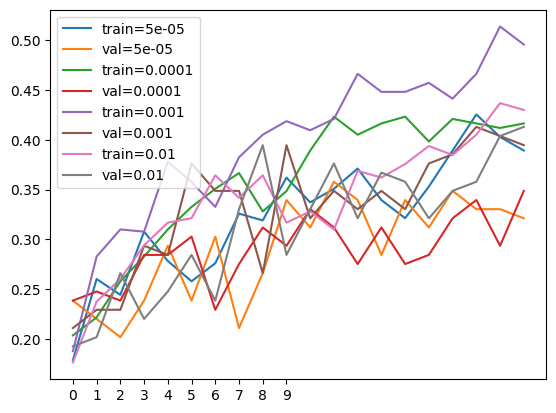

In [ ]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [ ]:
del scores[0.00005]

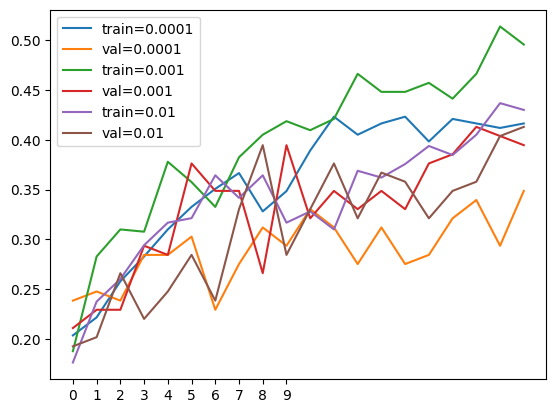

In [ ]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

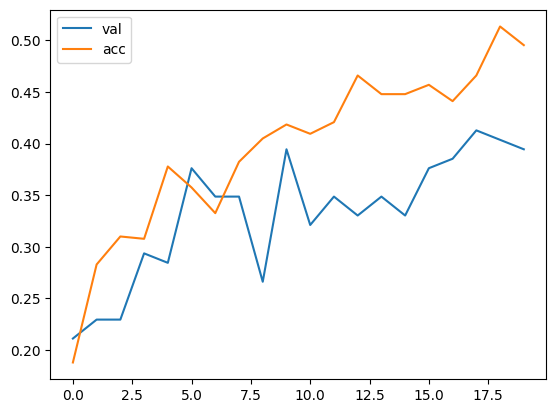

In [ ]:
hist = scores[0.001]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

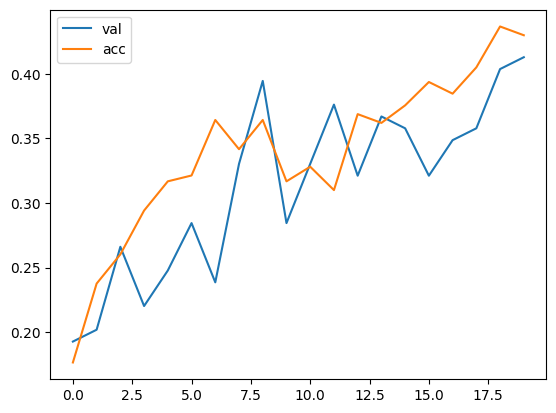

In [ ]:
hist = scores[0.01]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

**learning rate=0.01**

#### Dropout

In [ ]:
scores = {}

for do in [0.2, 0.3, 0.4, 0.5]:

  print(do)

  lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


  model = create_resnet50_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.01, dropout_rate=do, freeze_layers=4)
  model.summary()

  history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[lr_scheduler]
  )


  scores[do] = history.history

  print()
  print()

0.2


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 2,106,886 (8.04 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.1591 - loss: 5.7935 - val_accuracy: 0.1835 - val_loss: 14.4907 - learning_rate: 0.0100
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 445ms/step - accuracy: 0.2157 - loss: 1.8314 - val_accuracy: 0.1743 - val_loss: 3.4781 - learning_rate: 0.0100
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 374ms/step - accuracy: 0.1922 - loss: 1.7760 - val_accuracy: 0.2752 - val_loss: 2.5300 - learning_rate: 0.0100
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 319ms/step - accuracy: 0.2644 - loss: 1.7315 - val_accuracy: 0.2569 - val_loss: 2.1047 - learning_rate: 0.0100
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - accuracy: 0.2159 - loss: 1.7379 - val_accuracy: 0.2294 - val_loss: 2.0805 - learning_rate: 0.0100
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - accuracy: 0.2841 - loss: 1.6867 - val_accuracy: 0.1927 - val_loss: 1.9664 - learning_rate: 0.0100
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 310ms/step - accuracy: 0.3143 - loss: 1.6216 - v

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 2,106,886 (8.04 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.1602 - loss: 6.3326 - val_accuracy: 0.1835 - val_loss: 26.8488 - learning_rate: 0.0100
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 313ms/step - accuracy: 0.1940 - loss: 1.8348 - val_accuracy: 0.1835 - val_loss: 5.1357 - learning_rate: 0.0100
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 407ms/step - accuracy: 0.2335 - loss: 1.7632 - val_accuracy: 0.1835 - val_loss: 6.1380 - learning_rate: 0.0100
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 277ms/step - accuracy: 0.2170 - loss: 1.7685 - val_accuracy: 0.1927 - val_loss: 2.4437 - learning_rate: 0.0100
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 372ms/step - accuracy: 0.2291 - loss: 1.7290 - val_accuracy: 0.2110 - val_loss: 2.8625 - learning_rate: 0.0100
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 385ms/step - accuracy: 0.2247 - loss: 1.7118 - val_accuracy: 0.2844 - val_loss: 1.8322 - learning_rate: 0.0100
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - accuracy: 0.2453 - loss: 1.6696 - 

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 2,106,886 (8.04 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.1903 - loss: 5.0710 - val_accuracy: 0.1927 - val_loss: 5.0608 - learning_rate: 0.0100
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 408ms/step - accuracy: 0.2119 - loss: 1.8736 - val_accuracy: 0.1927 - val_loss: 4.9142 - learning_rate: 0.0100
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 317ms/step - accuracy: 0.2080 - loss: 1.7760 - val_accuracy: 0.1835 - val_loss: 2.6308 - learning_rate: 0.0100
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 365ms/step - accuracy: 0.2452 - loss: 1.7487 - val_accuracy: 0.3119 - val_loss: 2.0161 - learning_rate: 0.0100
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 370ms/step - accuracy: 0.2258 - loss: 1.7242 - val_accuracy: 0.2385 - val_loss: 1.8426 - learning_rate: 0.0100
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 327ms/step - accuracy: 0.2628 - loss: 1.7312 - val_accuracy: 0.2294 - val_loss: 1.8649 - learning_rate: 0.0100
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 293ms/step - accuracy: 0.2444 - loss: 1.6938 - 

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 2,106,886 (8.04 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.1801 - loss: 5.0110 - val_accuracy: 0.1927 - val_loss: 20.6445 - learning_rate: 0.0100
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 291ms/step - accuracy: 0.2409 - loss: 1.9906 - val_accuracy: 0.1835 - val_loss: 6.9486 - learning_rate: 0.0100
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 315ms/step - accuracy: 0.2484 - loss: 1.7682 - val_accuracy: 0.2018 - val_loss: 3.3576 - learning_rate: 0.0100
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 397ms/step - accuracy: 0.2818 - loss: 1.7034 - val_accuracy: 0.2569 - val_loss: 1.8709 - learning_rate: 0.0100
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 323ms/step - accuracy: 0.2385 - loss: 1.7381 - val_accuracy: 0.2661 - val_loss: 1.8766 - learning_rate: 0.0100
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 359ms/step - accuracy: 0.3108 - loss: 1.6697 - val_accuracy: 0.2294 - val_loss: 1.9663 - learning_rate: 0.0100
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.2703 - loss: 1.6879 

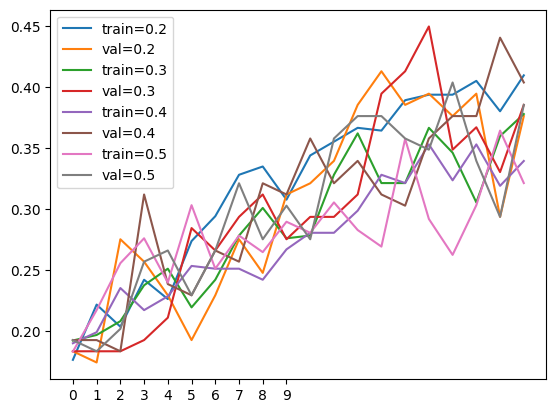

In [ ]:
for do, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % do))
    plt.plot(hist['val_accuracy'], label=('val=%s' % do))

plt.xticks(np.arange(10))
plt.legend()

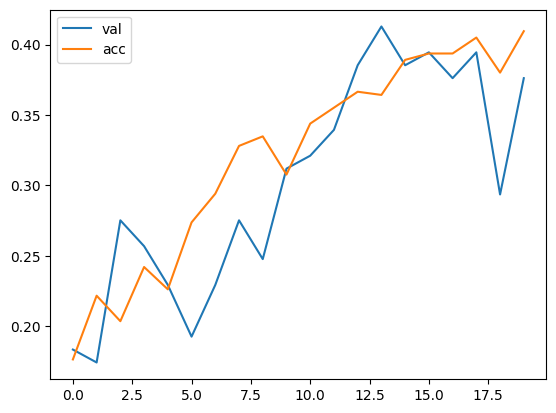

In [ ]:
hist = scores[0.2]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

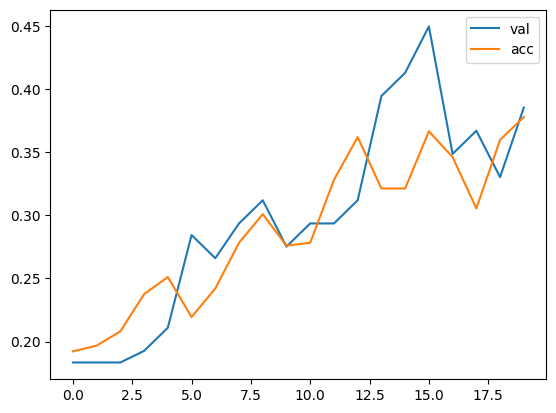

In [ ]:
hist = scores[0.3]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

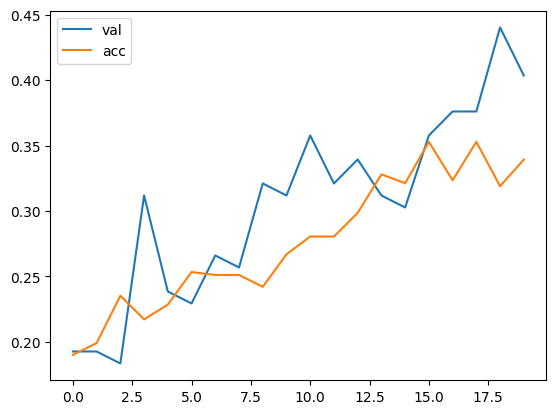

In [ ]:
hist = scores[0.4]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

#### Finetunig number of layers in base model

In [ ]:
scores = {}

for layer in [4, 6, 8, 10]:

  print(layer)

  lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

  model = create_resnet50_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.01, dropout_rate=0.3, freeze_layers=layer)

  model.summary()

  history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[lr_scheduler]
  )


  scores[layer] = history.history

  print()
  print()

4


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_14          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 2,106,886 (8.04 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.2028 - loss: 5.5235 - val_accuracy: 0.1376 - val_loss: 33.1593 - learning_rate: 0.0100
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 370ms/step - accuracy: 0.1747 - loss: 1.8992 - val_accuracy: 0.1835 - val_loss: 5.7019 - learning_rate: 0.0100
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 359ms/step - accuracy: 0.2343 - loss: 1.7623 - val_accuracy: 0.1835 - val_loss: 5.1107 - learning_rate: 0.0100
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step - accuracy: 0.2269 - loss: 1.7295 - val_accuracy: 0.1835 - val_loss: 3.3630 - learning_rate: 0.0100
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 285ms/step - accuracy: 0.2814 - loss: 1.6534 - val_accuracy: 0.1376 - val_loss: 2.4087 - learning_rate: 0.0100
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 371ms/step - accuracy: 0.2627 - loss: 1.6956 - val_accuracy: 0.2477 - val_loss: 1.8488 - learning_rate: 0.0100
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 353ms/step - accuracy: 0.2922 - loss: 1.6239 -

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_15          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 2,107,910 (8.04 MB)

 Non-trainable params: 22,531,968 (85.95 MB)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.1527 - loss: 7.2260 - val_accuracy: 0.2202 - val_loss: 3.5003 - learning_rate: 0.0100
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 390ms/step - accuracy: 0.2403 - loss: 1.8250 - val_accuracy: 0.1651 - val_loss: 1.8231 - learning_rate: 0.0100
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 309ms/step - accuracy: 0.2037 - loss: 1.7484 - val_accuracy: 0.3028 - val_loss: 1.7171 - learning_rate: 0.0100
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 295ms/step - accuracy: 0.2436 - loss: 1.7113 - val_accuracy: 0.2936 - val_loss: 1.7206 - learning_rate: 0.0100
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 369ms/step - accuracy: 0.2720 - loss: 1.6778 - val_accuracy: 0.3670 - val_loss: 1.6755 - learning_rate: 0.0100
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step - accuracy: 0.2648 - loss: 1.6736 - val_accuracy: 0.2569 - val_loss: 1.6899 - learning_rate: 0.0100
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 408ms/step - accuracy: 0.3400 - loss: 1.6116 - va

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_16          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 4,467,718 (17.04 MB)

 Non-trainable params: 20,172,160 (76.95 MB)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 982ms/step - accuracy: 0.2310 - loss: 5.2827 - val_accuracy: 0.1560 - val_loss: 86.8583 - learning_rate: 0.0100
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 27s 374ms/step - accuracy: 0.1983 - loss: 1.8363 - val_accuracy: 0.1560 - val_loss: 13.0484 - learning_rate: 0.0100
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 278ms/step - accuracy: 0.2289 - loss: 1.7474 - val_accuracy: 0.2018 - val_loss: 3.9889 - learning_rate: 0.0100
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 300ms/step - accuracy: 0.2616 - loss: 1.7320 - val_accuracy: 0.2202 - val_loss: 3.1357 - learning_rate: 0.0100
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 490ms/step - accuracy: 0.2809 - loss: 1.6812 - val_accuracy: 0.2569 - val_loss: 2.7753 - learning_rate: 0.0100
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step - accuracy: 0.2591 - loss: 1.6681 - val_accuracy: 0.2477 - val_loss: 2.1312 - learning_rate: 0.0100
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 293ms/step - accuracy: 0.3124 - loss: 1.63

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_17          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 5,517,830 (21.05 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.1664 - loss: 6.2421 - val_accuracy: 0.2569 - val_loss: 160.3231 - learning_rate: 0.0100
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 400ms/step - accuracy: 0.1623 - loss: 1.8303 - val_accuracy: 0.1927 - val_loss: 56.4372 - learning_rate: 0.0100
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 382ms/step - accuracy: 0.1939 - loss: 1.7663 - val_accuracy: 0.1927 - val_loss: 28.0256 - learning_rate: 0.0100
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 295ms/step - accuracy: 0.2077 - loss: 1.7586 - val_accuracy: 0.1927 - val_loss: 14.8463 - learning_rate: 0.0100
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 373ms/step - accuracy: 0.2524 - loss: 1.7177 - val_accuracy: 0.1927 - val_loss: 10.0926 - learning_rate: 0.0100
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - accuracy: 0.2743 - loss: 1.6990 - val_accuracy: 0.1927 - val_loss: 6.8741 - learning_rate: 0.0100
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 300ms/step - accuracy: 0.2553 - loss: 1.66

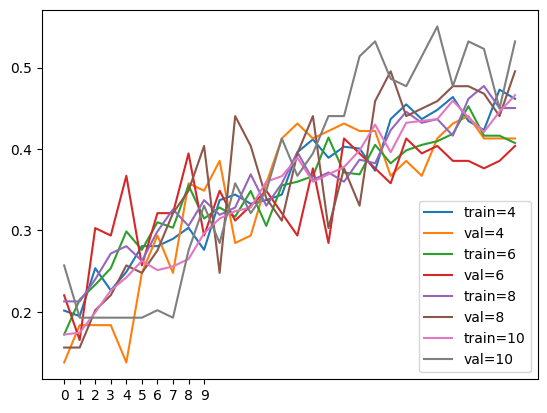

In [ ]:
for layer, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % layer))
    plt.plot(hist['val_accuracy'], label=('val=%s' % layer))

plt.xticks(np.arange(10))
plt.legend()

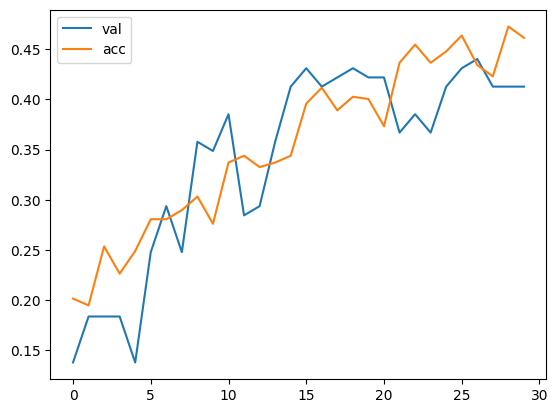

In [ ]:
hist = scores[4]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

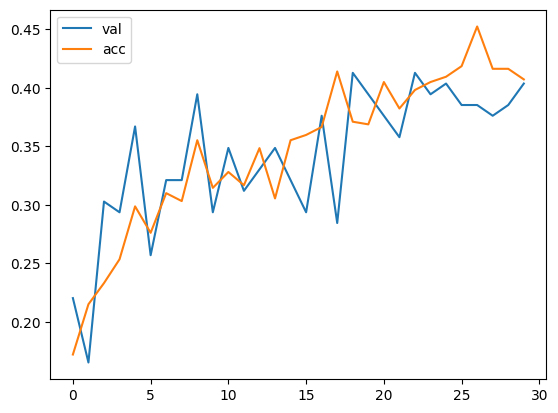

In [ ]:
hist = scores[6]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

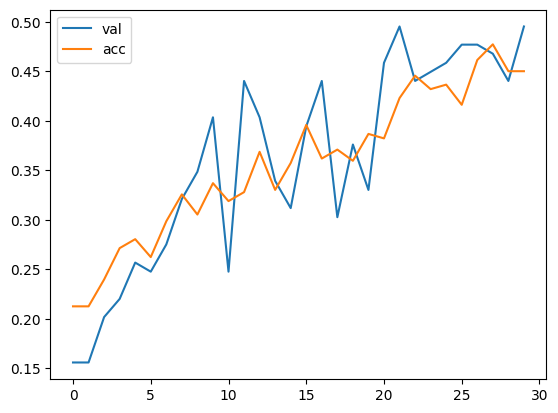

In [ ]:
hist = scores[8]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

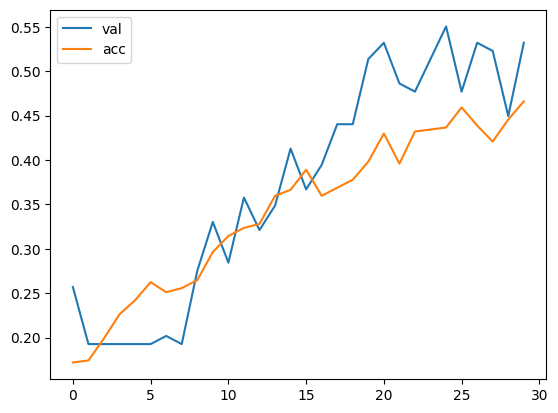

In [ ]:
hist = scores[10]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

In [ ]:
model = create_resnet50_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.01, dropout_rate=0.3, freeze_layers=10)
model.summary()

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[lr_scheduler]
  )


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_18          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 5,517,830 (21.05 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.1711 - loss: 6.5004 - val_accuracy: 0.1927 - val_loss: 1096.8915 - learning_rate: 0.0100
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 352ms/step - accuracy: 0.2086 - loss: 1.7993 - val_accuracy: 0.1927 - val_loss: 158.3063 - learning_rate: 0.0100
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 340ms/step - accuracy: 0.2344 - loss: 1.7843 - val_accuracy: 0.1927 - val_loss: 43.2194 - learning_rate: 0.0100
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 419ms/step - accuracy: 0.2839 - loss: 1.7455 - val_accuracy: 0.1835 - val_loss: 13.2295 - learning_rate: 0.0100
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 375ms/step - accuracy: 0.2396 - loss: 1.7436 - val_accuracy: 0.1743 - val_loss: 6.4267 - learning_rate: 0.0100
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 303ms/step - accuracy: 0.2716 - loss: 1.7022 - val_accuracy: 0.1927 - val_loss: 4.7222 - learning_rate: 0.0100
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 287ms/step - accuracy: 0.2359 - loss: 1.

### Xception Model

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


def create_xception_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.001, dropout_rate=0.4, freeze_layers=8):
    # Load the pre-trained Xception model without the top layer
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

    # Set the base model to trainable
    base_model.trainable = True

    # Freeze the initial layers up to the freeze_layers index
    for layer in base_model.layers[:-freeze_layers]:
        layer.trainable = False

    # Add custom layers on top
    model = models.Sequential([
        base_model,  # Add the Xception base model
        layers.GlobalAveragePooling2D(),  # Pooling layer to reduce spatial dimensions
        layers.Dropout(dropout_rate),  # Add dropout for regularization
        layers.Dense(512, activation='relu'),  # Fully connected layer
        layers.Dropout(dropout_rate),  # Another dropout layer
        layers.Dense(num_classes, activation='softmax')  # Output layer for classification
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class tasks
        metrics=['accuracy']
    )

    return model

In [ ]:
# Create the Xception model
model = create_xception_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.0001, dropout_rate=0.2, freeze_layers=8)

# Print model summary
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,913,646 (83.59 MB)

 Trainable params: 5,803,014 (22.14 MB)

 Non-trainable params: 16,110,632 (61.46 MB)

In [ ]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


history = model.fit(
    train_ds,  # Replace with your training dataset
    validation_data=val_ds,  # Replace with your validation dataset
    epochs=20,
    callbacks=[lr_scheduler]  # Optional learning rate scheduler
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.1960 - loss: 1.8355 - val_accuracy: 0.4128 - val_loss: 1.4945 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 328ms/step - accuracy: 0.4250 - loss: 1.5538 - val_accuracy: 0.6239 - val_loss: 1.2319 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 450ms/step - accuracy: 0.5475 - loss: 1.3886 - val_accuracy: 0.6606 - val_loss: 1.0090 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 374ms/step - accuracy: 0.6538 - loss: 1.1385 - val_accuracy: 0.7064 - val_loss: 0.7990 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 375ms/step - accuracy: 0.6631 - loss: 1.0898 - val_accuracy: 0.6881 - val_loss: 0.7754 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 394ms/step - accuracy: 0.7056 - loss: 0.9038 - val_accuracy: 0.6972 - val_loss: 0.6796 - learning_rate: 1.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 348ms/step - accuracy: 0.7795 - los

#### Parameter tuning

#### Learning rate

In [ ]:
scores = {}

for lr in [0.00005, 0.0001, 0.001, 0.01]:

  print(lr)

  lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


  model = create_xception_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=lr, dropout_rate=0.2, freeze_layers=8)
  model.summary()

  history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[lr_scheduler]
  )


  scores[lr] = history.history

  print()
  print()

5e-05


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,913,646 (83.59 MB)

 Trainable params: 5,803,014 (22.14 MB)

 Non-trainable params: 16,110,632 (61.46 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 862ms/step - accuracy: 0.2005 - loss: 1.8058 - val_accuracy: 0.3119 - val_loss: 1.6650 - learning_rate: 5.0000e-05
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 401ms/step - accuracy: 0.3129 - loss: 1.7000 - val_accuracy: 0.3853 - val_loss: 1.4907 - learning_rate: 5.0000e-05
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 289ms/step - accuracy: 0.4515 - loss: 1.5550 - val_accuracy: 0.4679 - val_loss: 1.3429 - learning_rate: 5.0000e-05
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 301ms/step - accuracy: 0.5393 - loss: 1.4266 - val_accuracy: 0.6147 - val_loss: 1.1682 - learning_rate: 5.0000e-05
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 406ms/step - accuracy: 0.5534 - loss: 1.3480 - val_accuracy: 0.6422 - val_loss: 1.0661 - learning_rate: 5.0000e-05
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.6066 - loss: 1.2225 - val_accuracy: 0.6606 - val_loss: 0.9784 - learning_rate: 5.0000e-05
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 378ms/step - accuracy

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,913,646 (83.59 MB)

 Trainable params: 5,803,014 (22.14 MB)

 Non-trainable params: 16,110,632 (61.46 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 872ms/step - accuracy: 0.1775 - loss: 1.8544 - val_accuracy: 0.4404 - val_loss: 1.5457 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 294ms/step - accuracy: 0.4661 - loss: 1.5010 - val_accuracy: 0.5596 - val_loss: 1.2317 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - accuracy: 0.5113 - loss: 1.3813 - val_accuracy: 0.5596 - val_loss: 1.0585 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 331ms/step - accuracy: 0.6495 - loss: 1.1741 - val_accuracy: 0.6330 - val_loss: 0.9132 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 293ms/step - accuracy: 0.6782 - loss: 1.0414 - val_accuracy: 0.6697 - val_loss: 0.8190 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 318ms/step - accuracy: 0.6936 - loss: 0.9155 - val_accuracy: 0.7339 - val_loss: 0.6803 - learning_rate: 1.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 385ms/step - accura

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,913,646 (83.59 MB)

 Trainable params: 5,803,014 (22.14 MB)

 Non-trainable params: 16,110,632 (61.46 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 890ms/step - accuracy: 0.3715 - loss: 1.6144 - val_accuracy: 0.6789 - val_loss: 0.7723 - learning_rate: 0.0010
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 296ms/step - accuracy: 0.7417 - loss: 0.7775 - val_accuracy: 0.7523 - val_loss: 0.5591 - learning_rate: 0.0010
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.8315 - loss: 0.4804 - val_accuracy: 0.7339 - val_loss: 0.8093 - learning_rate: 0.0010
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 398ms/step - accuracy: 0.8291 - loss: 0.4379 - val_accuracy: 0.7798 - val_loss: 0.8922 - learning_rate: 0.0010
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 329ms/step - accuracy: 0.8820 - loss: 0.3380 - val_accuracy: 0.7615 - val_loss: 0.9490 - learning_rate: 0.0010
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - accuracy: 0.9167 - loss: 0.2716 - val_accuracy: 0.7706 - val_loss: 0.5620 - learning_rate: 5.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 345ms/step - accuracy: 0.9309 - loss: 0.2

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,913,646 (83.59 MB)

 Trainable params: 5,803,014 (22.14 MB)

 Non-trainable params: 16,110,632 (61.46 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 909ms/step - accuracy: 0.3096 - loss: 2.3341 - val_accuracy: 0.3945 - val_loss: 19.7825 - learning_rate: 0.0100
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 410ms/step - accuracy: 0.5220 - loss: 1.2210 - val_accuracy: 0.5780 - val_loss: 7.7632 - learning_rate: 0.0100
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 307ms/step - accuracy: 0.6221 - loss: 0.9806 - val_accuracy: 0.5872 - val_loss: 9.9687 - learning_rate: 0.0100
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 313ms/step - accuracy: 0.7343 - loss: 0.8250 - val_accuracy: 0.6789 - val_loss: 5.6381 - learning_rate: 0.0100
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 402ms/step - accuracy: 0.7313 - loss: 0.7757 - val_accuracy: 0.5872 - val_loss: 6.5620 - learning_rate: 0.0100
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 332ms/step - accuracy: 0.7294 - loss: 0.8333 - val_accuracy: 0.7064 - val_loss: 1.9533 - learning_rate: 0.0100
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 320ms/step - accuracy: 0.7921 - loss: 0.5718

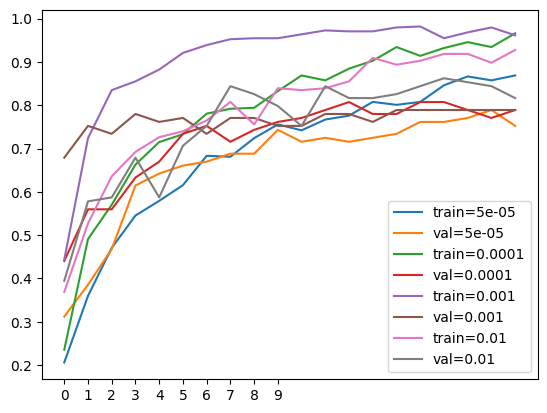

In [ ]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [ ]:
del scores[0.001]

del scores[0.01]

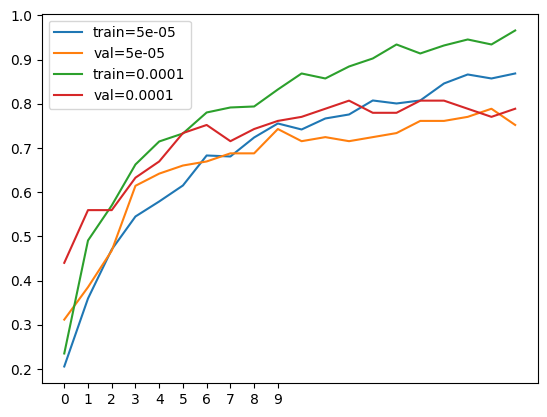

In [ ]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

**learning rate = 0.0001**

#### Dropout

In [ ]:
scores = {}

for do in [0.2, 0.3, 0.4, 0.5]:

  print(do)

  lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


  model = create_xception_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.0001, dropout_rate=do, freeze_layers=8)
  model.summary()

  history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[lr_scheduler]
  )


  scores[do] = history.history

  print()
  print()

0.2


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,913,646 (83.59 MB)

 Trainable params: 5,803,014 (22.14 MB)

 Non-trainable params: 16,110,632 (61.46 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.2245 - loss: 1.7878 - val_accuracy: 0.3945 - val_loss: 1.5022 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step - accuracy: 0.4245 - loss: 1.5161 - val_accuracy: 0.6147 - val_loss: 1.2232 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step - accuracy: 0.5465 - loss: 1.2827 - val_accuracy: 0.6422 - val_loss: 1.0716 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 419ms/step - accuracy: 0.6484 - loss: 1.1262 - val_accuracy: 0.7339 - val_loss: 0.8506 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 330ms/step - accuracy: 0.6797 - loss: 1.0028 - val_accuracy: 0.6789 - val_loss: 0.7865 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 325ms/step - accuracy: 0.7146 - loss: 0.9070 - val_accuracy: 0.7615 - val_loss: 0.6794 - learning_rate: 1.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 409ms/step - accuracy: 

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,913,646 (83.59 MB)

 Trainable params: 5,803,014 (22.14 MB)

 Non-trainable params: 16,110,632 (61.46 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 943ms/step - accuracy: 0.1829 - loss: 1.8300 - val_accuracy: 0.3945 - val_loss: 1.5132 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 312ms/step - accuracy: 0.4334 - loss: 1.5412 - val_accuracy: 0.5505 - val_loss: 1.2555 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 296ms/step - accuracy: 0.5325 - loss: 1.3786 - val_accuracy: 0.5688 - val_loss: 1.0929 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 377ms/step - accuracy: 0.5272 - loss: 1.2584 - val_accuracy: 0.6606 - val_loss: 0.9197 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 302ms/step - accuracy: 0.6481 - loss: 1.0928 - val_accuracy: 0.6881 - val_loss: 0.8244 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 284ms/step - accuracy: 0.6638 - loss: 0.9677 - val_accuracy: 0.7156 - val_loss: 0.7669 - learning_rate: 1.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 386ms/step - accurac

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,913,646 (83.59 MB)

 Trainable params: 5,803,014 (22.14 MB)

 Non-trainable params: 16,110,632 (61.46 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 896ms/step - accuracy: 0.1583 - loss: 1.8787 - val_accuracy: 0.3761 - val_loss: 1.5531 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step - accuracy: 0.3490 - loss: 1.6513 - val_accuracy: 0.4587 - val_loss: 1.3097 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 299ms/step - accuracy: 0.4769 - loss: 1.4565 - val_accuracy: 0.5596 - val_loss: 1.1575 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 364ms/step - accuracy: 0.5222 - loss: 1.3837 - val_accuracy: 0.5780 - val_loss: 1.0476 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 291ms/step - accuracy: 0.5991 - loss: 1.1902 - val_accuracy: 0.6789 - val_loss: 0.9092 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 296ms/step - accuracy: 0.6011 - loss: 1.1260 - val_accuracy: 0.6789 - val_loss: 0.8109 - learning_rate: 1.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 382ms/step - accura

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,913,646 (83.59 MB)

 Trainable params: 5,803,014 (22.14 MB)

 Non-trainable params: 16,110,632 (61.46 MB)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.1983 - loss: 1.9277 - val_accuracy: 0.3761 - val_loss: 1.6124 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 354ms/step - accuracy: 0.3126 - loss: 1.6962 - val_accuracy: 0.5321 - val_loss: 1.4023 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 361ms/step - accuracy: 0.3959 - loss: 1.5842 - val_accuracy: 0.6239 - val_loss: 1.2302 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 323ms/step - accuracy: 0.4675 - loss: 1.4731 - val_accuracy: 0.6606 - val_loss: 1.0903 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 343ms/step - accuracy: 0.4835 - loss: 1.3654 - val_accuracy: 0.6789 - val_loss: 0.9654 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 315ms/step - accuracy: 0.5372 - loss: 1.2729 - val_accuracy: 0.6881 - val_loss: 0.8650 - learning_rate: 1.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 383ms/step - accuracy:

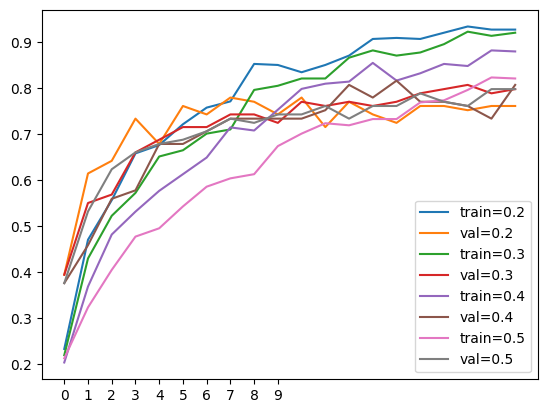

In [ ]:
for do, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % do))
    plt.plot(hist['val_accuracy'], label=('val=%s' % do))

plt.xticks(np.arange(10))
plt.legend()

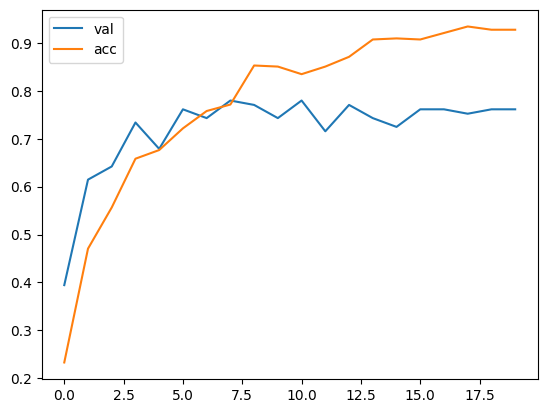

In [ ]:
hist = scores[0.2]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

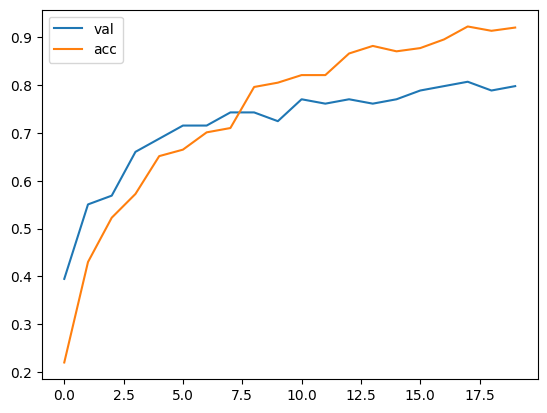

In [ ]:
hist = scores[0.3]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

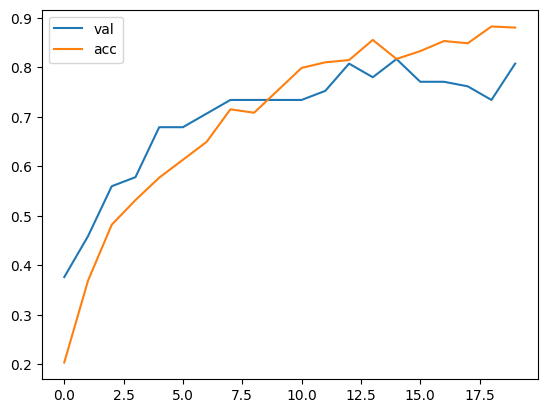

In [ ]:
hist = scores[0.4]
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='acc')
plt.legend()

**dropout=0.4**

#### Finetuning number of layers in base model

In [ ]:
scores = {}

for layer in [6, 8, 10, 12]:

  print(layer)

  lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


  model = create_xception_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.0001, dropout_rate=0.4, freeze_layers=layer)
  model.summary()

  history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[lr_scheduler]
  )


  scores[layer] = history.history

  print()
  print()

6


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,913,646 (83.59 MB)

 Trainable params: 5,800,966 (22.13 MB)

 Non-trainable params: 16,112,680 (61.46 MB)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 921ms/step - accuracy: 0.2002 - loss: 1.8741 - val_accuracy: 0.4037 - val_loss: 1.5124 - learning_rate: 1.0000e-04
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 322ms/step - accuracy: 0.3291 - loss: 1.5897 - val_accuracy: 0.5046 - val_loss: 1.3320 - learning_rate: 1.0000e-04
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 399ms/step - accuracy: 0.4534 - loss: 1.4300 - val_accuracy: 0.5780 - val_loss: 1.1425 - learning_rate: 1.0000e-04
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - accuracy: 0.5590 - loss: 1.2807 - val_accuracy: 0.6514 - val_loss: 0.9897 - learning_rate: 1.0000e-04
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 420ms/step - accuracy: 0.5963 - loss: 1.1370 - val_accuracy: 0.6972 - val_loss: 0.8790 - learning_rate: 1.0000e-04
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 378ms/step - accuracy: 0.6255 - loss: 1.0592 - val_accuracy: 0.7064 - val_loss: 0.7908 - learning_rate: 1.0000e-04
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step - accurac

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_10          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,913,646 (83.59 MB)

 Trainable params: 5,803,014 (22.14 MB)

 Non-trainable params: 16,110,632 (61.46 MB)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 922ms/step - accuracy: 0.1919 - loss: 1.8855 - val_accuracy: 0.4312 - val_loss: 1.5992 - learning_rate: 1.0000e-04
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - accuracy: 0.3432 - loss: 1.6679 - val_accuracy: 0.5046 - val_loss: 1.3749 - learning_rate: 1.0000e-04
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 296ms/step - accuracy: 0.4080 - loss: 1.5174 - val_accuracy: 0.5413 - val_loss: 1.2154 - learning_rate: 1.0000e-04
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 398ms/step - accuracy: 0.4909 - loss: 1.3771 - val_accuracy: 0.5963 - val_loss: 1.0585 - learning_rate: 1.0000e-04
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 337ms/step - accuracy: 0.6256 - loss: 1.2029 - val_accuracy: 0.5780 - val_loss: 0.9728 - learning_rate: 1.0000e-04
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 309ms/step - accuracy: 0.6439 - loss: 1.0864 - val_accuracy: 0.6239 - val_loss: 0.8796 - learning_rate: 1.0000e-04
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 319ms/step - accurac

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_11          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,913,646 (83.59 MB)

 Trainable params: 6,548,486 (24.98 MB)

 Non-trainable params: 15,365,160 (58.61 MB)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 967ms/step - accuracy: 0.2071 - loss: 1.8188 - val_accuracy: 0.4128 - val_loss: 1.5445 - learning_rate: 1.0000e-04
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 414ms/step - accuracy: 0.3359 - loss: 1.6504 - val_accuracy: 0.4679 - val_loss: 1.3532 - learning_rate: 1.0000e-04
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 326ms/step - accuracy: 0.4581 - loss: 1.4861 - val_accuracy: 0.5780 - val_loss: 1.1614 - learning_rate: 1.0000e-04
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 301ms/step - accuracy: 0.4887 - loss: 1.3585 - val_accuracy: 0.6330 - val_loss: 1.0288 - learning_rate: 1.0000e-04
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 372ms/step - accuracy: 0.5613 - loss: 1.2245 - val_accuracy: 0.6881 - val_loss: 0.9074 - learning_rate: 1.0000e-04
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 330ms/step - accuracy: 0.6089 - loss: 1.1021 - val_accuracy: 0.6881 - val_loss: 0.8322 - learning_rate: 1.0000e-04
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accura

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_12          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,913,646 (83.59 MB)

 Trainable params: 7,302,558 (27.86 MB)

 Non-trainable params: 14,611,088 (55.74 MB)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2292 - loss: 1.7848 - val_accuracy: 0.4495 - val_loss: 1.4898 - learning_rate: 1.0000e-04
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 371ms/step - accuracy: 0.3671 - loss: 1.6097 - val_accuracy: 0.4220 - val_loss: 1.3424 - learning_rate: 1.0000e-04
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step - accuracy: 0.4108 - loss: 1.5066 - val_accuracy: 0.6330 - val_loss: 1.0752 - learning_rate: 1.0000e-04
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 387ms/step - accuracy: 0.5542 - loss: 1.2674 - val_accuracy: 0.6422 - val_loss: 0.9619 - learning_rate: 1.0000e-04
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 396ms/step - accuracy: 0.6256 - loss: 1.1195 - val_accuracy: 0.6881 - val_loss: 0.8860 - learning_rate: 1.0000e-04
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 305ms/step - accuracy: 0.6177 - loss: 1.0338 - val_accuracy: 0.6972 - val_loss: 0.7727 - learning_rate: 1.0000e-04
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 365ms/step - accuracy: 0

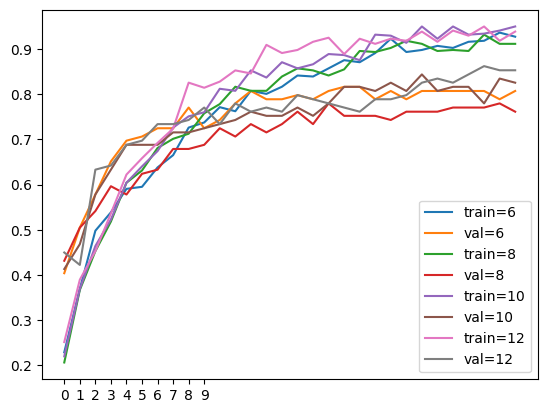

In [ ]:
for layer, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % layer))
    plt.plot(hist['val_accuracy'], label=('val=%s' % layer))

plt.xticks(np.arange(10))
plt.legend()

In [ ]:
model = create_xception_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.0001, dropout_rate=0.4, freeze_layers=10)
model.summary()

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[lr_scheduler]
  )

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,913,646 (83.59 MB)

 Trainable params: 6,548,486 (24.98 MB)

 Non-trainable params: 15,365,160 (58.61 MB)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 937ms/step - accuracy: 0.2284 - loss: 1.8353 - val_accuracy: 0.5229 - val_loss: 1.4715 - learning_rate: 1.0000e-04
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 352ms/step - accuracy: 0.3948 - loss: 1.5949 - val_accuracy: 0.5688 - val_loss: 1.2482 - learning_rate: 1.0000e-04
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 324ms/step - accuracy: 0.4341 - loss: 1.4881 - val_accuracy: 0.6606 - val_loss: 1.0553 - learning_rate: 1.0000e-04
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 301ms/step - accuracy: 0.5414 - loss: 1.3207 - val_accuracy: 0.6881 - val_loss: 0.9515 - learning_rate: 1.0000e-04
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 320ms/step - accuracy: 0.5359 - loss: 1.2125 - val_accuracy: 0.7248 - val_loss: 0.8250 - learning_rate: 1.0000e-04
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 359ms/step - accuracy: 0.6566 - loss: 1.0405 - val_accuracy: 0.7064 - val_loss: 0.7905 - learning_rate: 1.0000e-04
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 298ms/step - accura

### Model Selection
- **VGG19** is performing better than the other with the following parameters
- learning_rate=0.0001
- dropout_rate=0.4,
- finetune_layers = 8

In [10]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [11]:
def create_vgg19_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.0001, dropout_rate=0.4, freeze_layers = 8):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model
    base_model.trainable = True

    # Freeze all layers except the last few (to fine-tune only the last layers)
    for layer in base_model.layers[:-freeze_layers]:  # Unfreeze the last k layers
        layer.trainable = False

    model = models.Sequential([
        base_model,  # Add VGG19 as base model (without top layer)
        layers.GlobalAveragePooling2D(),  # Pooling layer to reduce spatial dimensions
        layers.Dropout(dropout_rate),  # Add dropout layer after pooling for regularization
        layers.Dense(512, activation='relu'),  # Fully connected layer with ReLU activation
        layers.Dropout(dropout_rate),  # Dropout after the dense layer
        layers.Dense(num_classes, activation='softmax')  # Output layer with softmax for classification
    ])

    # Compile the model with custom learning rate
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),  # Set the learning rate here
        loss='categorical_crossentropy',  # Multi-class classification
        metrics=['accuracy']
    )

    return model


In [12]:

# learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce learning rate by a factor of 0.5
    patience=3,          # Wait for 3 epochs before reducing
    min_lr=1e-6          # Minimum learning rate
)

# model checkpoint callback

checkpoint = ModelCheckpoint(
    'VGG19_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',  # Monitoring validation accuracy
    mode='max'            # Saving when val_accuracy improves
)


In [13]:

model = create_vgg19_model(input_shape=(150, 150, 3), num_classes=6, learning_rate=0.0001, dropout_rate= 0.4, freeze_layers = 8)
model.summary()




80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,290,118 (77.40 MB)

 Trainable params: 14,424,582 (55.03 MB)

 Non-trainable params: 5,865,536 (22.38 MB)

In [14]:
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[lr_scheduler, checkpoint]
  )

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.1685 - loss: 1.9174 - val_accuracy: 0.3578 - val_loss: 1.6336 - learning_rate: 1.0000e-04
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 540ms/step - accuracy: 0.2890 - loss: 1.6468 - val_accuracy: 0.5229 - val_loss: 1.2392 - learning_rate: 1.0000e-04
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step - accuracy: 0.5093 - loss: 1.3021 - val_accuracy: 0.7156 - val_loss: 0.8039 - learning_rate: 1.0000e-04
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 480ms/step - accuracy: 0.5931 - loss: 1.0476 - val_accuracy: 0.7982 - val_loss: 0.5951 - learning_rate: 1.0000e-04
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 332ms/step - accuracy: 0.6672 - loss: 0.8735 - val_accuracy: 0.7248 - val_loss: 0.6859 - learning_rate: 1.0000e-04
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 366ms/step - accuracy: 0.6133 - loss: 0.9298 - val_accuracy: 0.7706 - val_loss: 0.5231 - learning_rate: 1.0000e-04
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 471ms/step - accuracy: 0.7295 - 

Using this model

In [15]:

VGG19_model = keras.models.load_model('/content/VGG19_v1_14_0.945.keras')

#### Load image from URL.
- To use the finalized model.

In [3]:
import requests
import io
from PIL import Image
import numpy as np

def load_image_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()

        # Check Content-Type header
        content_type = response.headers.get('Content-Type', '')
        if 'image' not in content_type:
            raise ValueError(f"URL does not point to an image. Content-Type: {content_type}")

        # Attempt to open the image
        img = Image.open(io.BytesIO(response.content))
        return img
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

url = "https://thumbs.dreamstime.com/b/chess-flat-king-icon-stock-vector-image-royal-isolated-piece-outlined-214056020.jpg"
image = load_image_from_url(url)

if image is not None:
    # Convert image to numpy array
    x = np.array(image)
    print("Image loaded successfully. Shape:", x.shape)
else:
    print("Failed to load the image.")

Image loaded successfully. Shape: (800, 800, 3)


In [2]:
classes = ['Bishop',
           'King',
           'Knight',
           'Pawn',
           'Queen',
           'Rook']

In [20]:
def pred_chess(url):

    image = load_image_from_url(url)

    img = image.resize((150, 150), Image.NEAREST)

    x = np.array(img)
    X = np.array([x])
    print(X.shape)
    X = preprocess_input(X)
    pred = VGG19_model.predict(X)

    class_probabilities = dict(zip(classes, pred[0]))

    predicted_class = max(class_probabilities, key=class_probabilities.get)

    return predicted_class

In [21]:
url = "https://thumbs.dreamstime.com/b/chess-flat-king-icon-stock-vector-image-royal-isolated-piece-outlined-214056020.jpg"  # Replace with your actual image URL


pred_chess(url)

(1, 150, 150, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


'King'

In [22]:
url = 'https://thumbs.dreamstime.com/z/bishop-chess-piece-wooden-isolated-clipping-path-included-43949803.jpg'


pred_chess(url)

(1, 150, 150, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


'Bishop'

In [23]:
url = 'https://images.chesscomfiles.com/uploads/v1/article/15680.8ba56ba3.5000x5000o.1c5591a9bd76.jpeg'

pred_chess(url)

(1, 150, 150, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


'Rook'

### Clear cache

In [ ]:
# clear session once more after all epochs
K.clear_session()